---
title: "Time Series Alarm Forecasting"
author: "Thomas Stoeckl"
date: "2025-02-27"
jupyter: ipykernel
format:
  html:
    toc: true
    number-sections: true
    embed-resources: true
    cite-method: citeproc
    highlight-style: tango
    css: styles.css

execute:
  echo: false
  warning: false
  message: false
  error: false


crossref:
  eq-prefix: Eq.
  fig-prefix: Fig.
  tbl-prefix: Table
  sec-prefix: Section

bibliography: "references.bib"

---


\newpage

<!-- ---
title: "Time Series Alarm Forecasting"
author: "Thomas Stoeckl"
date: today
jupyter: ipykernel
format:
  pdf:
    documentclass: scrartcl     
    classoption:
      - oneside
    papersize: a4
    fontsize: 11pt
    geometry:
      - margin=1in
    fig-pos: "H"
    cite-method: biblatex
    biblatexoptions:
      - sorting=none
    # template-partials:
    #   - title.tex

    mainfont: "Latin Modern Roman"
    monofont: "Latin Modern Mono"
    mathfont: "Latin Modern Math"

    keep-tex: false               
    toc: true
    number-sections: true

    highlight-style: tango
    listings: true

execute:
  echo: false
  warning: false
  message: false
  error: false


crossref:
  eq-prefix: Eq.
  fig-prefix: Fig.
  tbl-prefix: Table
  sec-prefix: Section
header-includes:
  - \usepackage{float}
  - \usepackage{enumitem}
  - \usepackage{graphicx}




bibliography: "references.bib"

--- -->


# Overview
Alarm management is a critical aspect of industrial automation and control systems. It involves the systematic handling of alarms generated by various processes and equipment to ensure timely response and resolution of issues. Effective alarm management helps in minimizing downtime, improving safety, and enhancing overall operational efficiency. In this project, we focus on forecasting time series data related to alarms, which can help in predicting future alarm occurrences and trends. By leveraging advanced forecasting techniques, we aim to provide insights that can aid in proactive maintenance and decision-making. 

In @sec-model, we describe the forecasting models, @sec-data-prep-exploration covers data preparation and exploration, providing insight into the dataset. @sec-results presents the forecasting results, and @sec-conclusion closes with key findings and future directions.

# Models {#sec-model}
In this section, we provide a concise overview of the four primary models employed for time series forecasting in this project: SARIMAX, Extreme Gradient Boosting (XGBoost), Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM). Each model is briefly described along with its mathematical formulation to elucidate its underlying principles and mechanisms.

## SARIMAX
ARIMA [@arima] is described as a statistical approach for time-series forecasting under random errors, structured around three components: autoregression (AR), integration (I) , and moving average (MA). Its order is denoted by $(p,d,q)$, where $p$ is the number of AR lags, $d$ is the differencing order, and $q$ is the MA lag.

 SARIMAX is an extension of the ARIMA family that includes both seasonal dynamics and exogenous variables to improve forecasting performance [@sarimax].

Seasonal dynamics are incorporated via the seasonal order $(P,D,Q)^s$ in addition to the non-seasonal order $(p,d,q)$, where $s$ is the number of time steps per season. Here, $P$ is the seasonal AR lag, $D$ is the seasonal differencing order, and $Q$ is the seasonal MA lag. The backshift operator is denoted by $G$, the observed series by $x_t$, and the prediction error by $e_t$.

$$
\phi_p(G) \phi_P(G^s) (1-G)^d (1-G^s)^D x_t =
\gamma_q(G) \omega_Q(G^s) e_t
$$

In this representation, $(1-G)^d$ is the non-seasonal differencing operator and $(1-G^s)^D$ is the seasonal differencing operator. The polynomials $\phi_p(G)$ and $\gamma_q(G)$ capture non-seasonal AR and MA behavior, while $\phi_P(G^s)$ and $\omega_Q(G^s)$ capture seasonal AR and seasonal MA behavior.

The characteristic polynomials are specified as follows.

$$
AR: \phi_p(G) = 1 - \phi_1G - \phi_2G^2 - \cdots - \phi_pG^p
$$

$$
MA: \gamma_q(G) = 1 - \gamma_1G - \gamma_2G^2 - \cdots - \gamma_qG^q
$$

$$
SAR: \phi_P(G^s) = 1 - \phi_1G^s - \phi_2G^{2s} - \cdots - \phi_PG^{Ps}
$$

$$
SMA: \omega_Q(G^s) = 1 - \omega_1G^s - \omega_2G^{2s} - \cdots - \omega_QG^{Qs}
$$


SARIMAX extends SARIMA by adding exogenous variables, which are external features that enhance predictive accuracy. These inputs can be modeled as parallel time series correlated with the target series. SARIMAX can be expressed as:

$$
\phi_p(G) \phi_P(G^s) (1-G)^d (1-G^s)^D x_t =
\sum_k\alpha_k y_{k,t} + \gamma_q(G) \omega_Q(G^s) e_t
$$

In this formulation, $k$ indexes the exogenous variables. $y_{k,t}$ denotes the value of the $k$-th exogenous factor at time $t$, and $\alpha_k$ is the coefficient associated with that factor. 



## XGBoost

XGBoost (Extreme Gradient Boosting) is a scalable gradient boosting framework based on decision trees. It constructs an ensemble of regression trees to approximate complex nonlinear relationships and is widely used due to its strong empirical performance and computational efficiency [@xgboost_2016].

Given data $\{(\boldsymbol{x}_i, y_i)\}_{i=1}^n$ with $\boldsymbol{x}_i \in \mathbb{R}^p$ and $y_i \in \mathbb{R}$, where $n$ is the number of observations and $p$ is the number of features, XGBoost models the prediction as an additive ensemble of trees:


$$
\hat{y}_i = \phi(\boldsymbol{x}_i) = \sum_{k=1}^{K} f_k(\boldsymbol{x}_i),
$$

where each $f_k$ is a regression tree mapping an input $\boldsymbol{x}_i$ to a leaf index and associated leaf weight. The ensemble is learned by minimizing the following objective:

$$
\mathcal{L}(\phi) = \sum_{i=1}^n L(\hat{y}_i, y_i) + \sum_{k=1}^K \Omega(f_k),
$$

where $L$ is a differentiable loss (e.g., squared error, logistic loss) and 

$$
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2
$$

penalizes the number of leaves $T$ and the magnitude of leaf weights $w_j$ to control model complexity. $\gamma$ and $\lambda$ are hyperparameters controlling the strength of regularization, 


XGBoost employs stagewise additive training. Let $\hat{y}_i^{(t)}$ denote the prediction for instance $i$ at iteration $t$. At step $t$, we need function $f_t$ that minimizes


$$
\mathcal{L}^{(t)} =
\sum_{i=1}^{n}
L\big(y_i, \hat{y}_i^{(t-1)} + f_t(\boldsymbol{x}_i)\big)
+ \Omega(f_t).
$$

The objective restricted to the new tree is approximated by a second-order Taylor expansion of the loss around $\hat{y}_i^{(t-1)}$. Defining first- and second-order derivatives

$$
g_i = \frac{\partial}{\partial \hat{y}_i^{(t-1)}} L(y_i, \hat{y}_i^{(t-1)}), 
\qquad
h_i = \frac{\partial^2}{\partial (\hat{y}_i^{(t-1)})^2} L(y_i, \hat{y}_i^{(t-1)}),
$$

the approximate objective for tree $f_t$ decomposes over leaves. If $I_j$ denotes the set of samples assigned to leaf $j$, the optimal leaf weight for leaf $j$ is

$$
w_j^\ast = - \frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda},
$$

and the corresponding score of a fixed tree structure is

$$
\tilde{\mathcal{L}}^{(t)}(q)
=
-\frac{1}{2}
\sum_{j=1}^{T}
\frac{\left(\sum_{i \in I_j} g_i\right)^2}
     {\sum_{i \in I_j} h_i + \lambda}
+ \gamma T.
$$

This scoring function is used to greedily construct trees: for a candidate split that partitions a node’s index set $I$ into $I_L$ and $I_R$, the loss reduction is

$$
\mathcal{L}_{\text{split}} =
\frac{1}{2}
\left[
\frac{\left(\sum_{i \in I_L} g_i\right)^2}{\sum_{i \in I_L} h_i + \lambda}
+
\frac{\left(\sum_{i \in I_R} g_i\right)^2}{\sum_{i \in I_R} h_i + \lambda}
-
\frac{\left(\sum_{i \in I} g_i\right)^2}{\sum_{i \in I} h_i + \lambda}
\right]
- \gamma.
$$



## RNN

A dynamical system is recursive and its classical form is given by

$$
h_t = f_\theta(h_{t-1}, x_t).
$$

Here, $t$ denotes the time step, $h_t$ is the hidden state at time $t$, and $f_\theta(\cdot)$ is a function fixed between the states of all time steps. With external inputs, $x_t$ denotes the input signal at time $t$ [@lstm].

The hidden state can be viewed as a summary of the past sequence of inputs and states. If a different function $f_\theta$ is used for each sequence length, the model cannot generalize. Generalization across sequences of arbitrary length requires sharing the same parameters at every time step and across all states. A dynamical system with such parameter sharing can be implemented as a neural network with weights; this is called a RNN (Recurrent Neural Network).

 Let $x_t \in \mathbb{R}^d$ denote the input, $h_t \in \mathbb{R}^p$ the hidden state, and $y_t \in \mathbb{R}^q$ the output at time step $t$. Here, $d$ is the input dimension (number of features), $p$ is the hidden-state dimension, and $q$ is the output dimension. Let $W \in \mathbb{R}^{p \times p}$ be the weight matrix between states, $U \in \mathbb{R}^{p \times d}$ the weight matrix between the inputs and states, and $V \in \mathbb{R}^{q \times p}$ the weight matrix between the states and outputs. The bias terms for the state and output are denoted by $b_i \in \mathbb{R}^p$ and $b_y \in \mathbb{R}^q$, respectively. A standard RNN, as shown in Fig. \ref{fig:rnn}, is defined by:


$$
\begin{aligned}
h_t &= \tanh(W h_{t-1} + U x_t + b_i) \\
y_t &= V h_t + b_y
\end{aligned}
$$


\begin{figure}[h]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/rnn.png}
    \caption{RNN}
    \label{fig:rnn}
\end{figure}


Training uses backpropagation through time. Because gradients are products across many time steps, long‑term dependencies can cause vanishing or exploding gradients.


## LSTM 

LSTM (Long Short-Term Memory) [@hochreiter] networks are a specialized class of RNNs designed to address the problem of learning long-term dependencies in sequential data. Unlike standard RNNs, LSTMs learn from the data itself when information should be retained over long time spans and when it should be discarded. This adaptive memory behavior allows LSTMs to model both short-term and long-term temporal dependencies effectively.

An LSTM processes a sequence of cells across time steps. This is illustrated in Fig. \ref{fig:lstm_chain}.


\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{figures/lstm_chain.png}
    \caption{Sequence of LSTM cells}
    \label{fig:lstm_chain}
\end{figure}

![Internal structure of an LSTM cell [@lstm]](figures/lstm_cell.png){#fig-lstm_cell width=80% fig-cap="Internal structure of an LSTM cell [@lstm]"}


At each time step, the LSTM cell computes three gates: the input gate, the forget gate, and the output gate, see @fig-lstm_cell. The gates are defined as:

$$
i_t = \sigma\left(W_i h_{t-1} + U_i x_t + p_i \odot c_{t-1} + b_i\right)
$$

$$
f_t = \sigma\left(W_f h_{t-1} + U_f x_t + p_f \odot c_{t-1} + b_f\right)
$$

$$
o_t = \sigma\left(W_o h_{t-1} + U_o x_t + p_o \odot c_t + b_o\right)
$$


where $W_\ast \in \mathbb{R}^{p \times p}$, $U_\ast \in \mathbb{R}^{p \times d}$, and $b_\ast \in \mathbb{R}^{p}$ are learnable weight matrices and bias vectors, $\sigma(\cdot)$ denotes the sigmoid function applied element-wise, $c_{t-1} \in \mathbb{R}^p$ is the final memory of the last time step. In each gate, a sigmoid function is applied, producing values in $[0,1]$, allowing them to control how much information is passed or blocked. The vectors $p_\ast \in \mathbb{R}^{p}$, are known as \emph{peephole connections}. [@lstm] They allow each gate to directly access the last or the current final memory, thereby enabling the gates to make decisions based not only on the input and hidden state. The symbol $\odot$ denotes the Hadamard (element-wise) product. The equation below defines the gate that combines the current input with the previous hidden state to capture new information:

$$
\tilde{c}_t = \tanh\left(W_c h_{t-1} + U_c x_t + b_c\right).
$$

Now we can calculate the final memory: 

$$
c_t = (f_t \odot c_{t-1}) + (i_t \odot \tilde{c}_t)
$$

which combines the previous final memory with new information. The forget gate $f_t$ determines how much of the previous final memory $c_{t-1}$ is preserved, while the input gate $i_t \in [0,1]^p$ and $\tilde{c}_t \in [-1,1]^p$ control how much of the new information is added to the final memory. Finally, the hidden state is computed as

$$
h_t = o_t \odot \tanh(c_t).
$$




# Data Preparation and Exploration {#sec-data-prep-exploration}
In this section, we will anlayse the alarm time series dataset [@industrial-alarm-kaggle], perform necessary preprocessing steps, and conduct exploratory data analysis to understand the underlying patterns and characteristics of the data. 
 

In [1]:
import kagglehub
import pandas as pd
from pathlib import Path
SEED = 1

In [2]:
# Download latest version
path_str = kagglehub.dataset_download("sudhanvahg/industrial-alarm-monitoring-dataset-2018-2024")

print("Path to dataset files:", path_str)

# Convert the path string to a Path object to easily work with files
path = Path(path_str)

# List all CSV files in the downloaded directory
csv_files = list(path.glob("*.csv"))

if csv_files:
    print(f"Found {len(csv_files)} CSV file(s) in the directory.")
    # Load the first CSV file into a pandas DataFrame
    data = pd.read_csv(csv_files[0])
    print("Successfully loaded the CSV file:", csv_files[0].name)
    print("First 5 rows of the dataset:")
else:
    print("No CSV files found in the downloaded directory.")


100%|██████████| 1.00M/1.00M [00:00<00:00, 77.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sudhanvahg/industrial-alarm-monitoring-dataset-2018-2024/versions/1
Found 1 CSV file(s) in the directory.


Successfully loaded the CSV file: preprocessed_trendedpointalarm 1.csv
First 5 rows of the dataset:


In [3]:
data.head() 

,DateTime,ProcessID,AssetID,AlarmSeverityName,State,TransactionMessage,Stage,AlarmClassName,Year,Month,Day,DayOfWeek,Season,Hour,ProcessedMessage
0,02-01-2018 22:45,IBMS/201801024100783,1-JK1-JK1-01-E.02-AC-ACON-VAVU-0047,3 - Low,A2N,VAV-J09-01-029 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,2,Tuesday,Winter,22,vavj0901029 space temp alarm
1,03-01-2018 01:41,IBMS/201801024101029,1-JK1-JK1-00-C.27-AC-ACON-VAVU-0019,3 - Low,A2N,VAV-J09-00-027 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,1,vavj0900027 space temp alarm
2,03-01-2018 03:08,IBMS/201801034101175,1-JK1-JK1-00-C.27-AC-ACON-VAVU-0019,3 - Low,A2N,VAV-J09-00-027 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,3,vavj0900027 space temp alarm
3,03-01-2018 07:12,IBMS/201801034101667,1-JK1-JK1-00-D.01-AC-ACON-VAVU-0021,3 - Low,A2N,VAV-J09-00-029 SPACE TEMP ALARM,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,7,vavj0900029 space temp alarm
4,03-01-2018 09:04,IBMS/201801034102043,0-JK1-JK1-B2-1.01-AC-ACON-MAHU-0003,2 - Medium,A2N,MAU-JK1-B1-001 Dis Air Temp,Cancelled,General-ELV,2018,1,3,Wednesday,Winter,9,maujk1b1001 dis air temp


## Alarm Dataset 

The dataset contains structured alarm event records from monitored industrial processes and assets. Each row represents a single alarm event and includes temporal and descriptive attributes. In total, there are 102,319 alarms. The records span 2015 through 2024 and include the following columns:

**Timestamp:** Exact date and time at which the alarm event occurred.  
**ProcessID:** Unique identifier of the process that generated the alarm.  
**AssetID:** Identifier of the asset associated with the alarm event.  
**AlarmSeverityName:** Severity level of the alarm, indicating its criticality (High, Medium, Low).  
**State:** Alarm state transition describing the change in condition (Normal to Abnormal, Abnormal to Normal, or Abnormal to Abnormal).  
**TransactionMessage:** Original system-generated message describing the alarm condition in detail.  
**Stage:** Operational lifecycle stage of the alarm, such as Cancelled or Cleared.  
**AlarmClassName:** Classification or category of the alarm reflecting its functional grouping.  
**Year:** Calendar year in which the alarm event occurred.  
**Month:** Calendar month in which the alarm event occurred.  
**Day:** Day of the month on which the alarm event occurred.  
**DayOfWeek:** Day of the week corresponding to the alarm event.  
**Season:** Season during which the alarm event occurred, derived from the event timestamp.  
**Hour:** Hour of the day at which the alarm was triggered.  
**ProcessedMessage:** Cleaned and standardized version of the alarm message, designed to support efficient analysis and downstream processing.

@tbl-missing-values summarizes missing values by column. All missing entries occur in string or categorical columns, so we impute them with *Unknown*.

\newpage


In [4]:
# Display information about the DataFrame (columns, non-null counts, dtypes)
print("\nDataFrame Info:")
data.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102319 entries, 0 to 102318
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   DateTime            102319 non-null  object
 1   ProcessID           102319 non-null  object
 2   AssetID             102048 non-null  object
 3   AlarmSeverityName   102319 non-null  object
 4   State               102319 non-null  object
 5   TransactionMessage  101725 non-null  object
 6   Stage               99335 non-null   object
 7   AlarmClassName      102319 non-null  object
 8   Year                102319 non-null  int64 
 9   Month               102319 non-null  int64 
 10  Day                 102319 non-null  int64 
 11  DayOfWeek           102319 non-null  object
 12  Season              102319 non-null  object
 13  Hour                102319 non-null  int64 
 14  ProcessedMessage    101725 non-null  object
dtypes: int64(4), object(11)
memory usa

In [5]:
#| tbl-cap: Missing Values in the Dataset
#| label: tbl-missing-values

# Check for null values in each column
null_counts = data.isnull().sum()
null_df = (
    null_counts[null_counts > 0]
    .sort_values(ascending=False)
    .rename("Missing")
    .reset_index()
    .rename(columns={"index": "Column"})
)

null_df["Missing in %"] = (null_df["Missing"] / len(data) * 100).round(2)

null_df



,Column,Missing,Missing in %
0,Stage,2984,2.92
1,TransactionMessage,594,0.58
2,ProcessedMessage,594,0.58
3,AssetID,271,0.26


In [6]:
# Fill NaN values with 'Unknown'
data.fillna('Unknown', inplace=True)

In [7]:
# Generate descriptive statistics for numerical columns ('Year', 'Month', 'Day', 'Hour') to understand their distribution and characteristics.
numerical_cols = ['Year', 'Month', 'Day', 'Hour']
descriptive_stats = data[numerical_cols].describe()
print("Descriptive statistics for numerical columns:")
descriptive_stats

Descriptive statistics for numerical columns:


,Year,Month,Day,Hour
count,102319.000000,102319.000000,102319.000000,102319.000000
mean,2021.547699,6.604287,15.899862,11.559847
std,1.808214,3.304413,8.749062,6.857471
min,2015.000000,1.000000,1.000000,0.000000
25%,2021.000000,4.000000,8.000000,6.000000
50%,2022.000000,6.000000,16.000000,12.000000
75%,2023.000000,10.000000,24.000000,17.000000
max,2024.000000,12.000000,31.000000,23.000000


In [ ]:
# Generate value counts for categorical columns to understand the distribution of categories.
categorical_cols = ['AlarmSeverityName', 'State', 'Stage', 'AlarmClassName', 'DayOfWeek', 'Season']
for col in categorical_cols:
    print(f"\nValue counts for column: {col}")
    print(data[col].value_counts())


Value counts for column: AlarmSeverityName
AlarmSeverityName
1 - High                         64042
3 - Low                          21160
2 - Medium                       16811
CPMS                               156
BACnet                             104
Meter                               45
Central Battery System-Medium        1
Name: count, dtype: int64

Value counts for column: State
State
A2N    91136
A2A     6717
N2A     4466
Name: count, dtype: int64

Value counts for column: Stage
Stage
Cancelled    79588
Cleared      14534
New           3758
Unknown       2984
Confirmed     1054
Acked          238
Escalated      163
Name: count, dtype: int64

Value counts for column: AlarmClassName
AlarmClassName
General-ELV                    79584
General-ELV-High               18214
LifeSafety                      2321
Security                        1348
CPMS                             319
Central Battery System           309
Meter Alarm                      104
SLA                     

## Feature Analysis

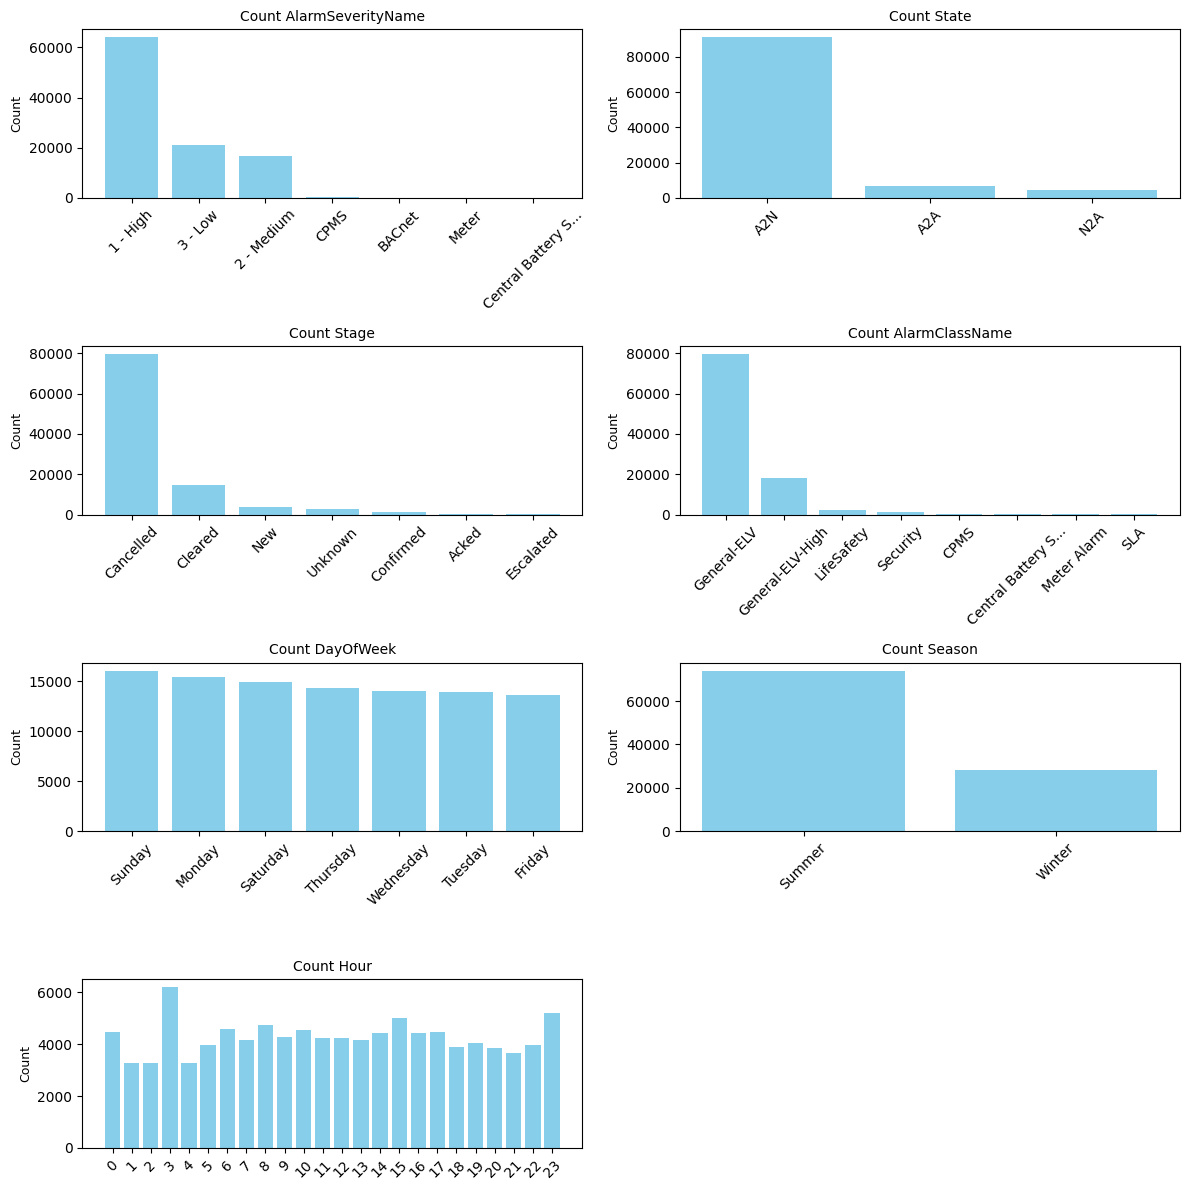

In [9]:
#| fig-cap: Count Plots for Categorical Variables
#| label: fig-categorical-counts

from matplotlib import pyplot as plt
plot_cols = ['AlarmSeverityName', 'State', 'Stage', 'AlarmClassName', 'DayOfWeek', 'Season', 'Hour']

def shorten_labels(labels, max_len=20):
    return [lbl if len(lbl) <= max_len else lbl[:max_len-3] + "..." for lbl in labels]

fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()
for i, col in enumerate(plot_cols):
    ax = axes[i]
    if col == 'Hour':
        counts = data[col].value_counts().sort_index()
        labels = [str(x) for x in counts.index]
    else:
        counts = data[col].value_counts().head(10)
        labels = counts.index.astype(str).tolist()

    short = shorten_labels(labels)
    ax.bar(short, counts.values, color='skyblue')
    ax.set_title(f'Count {col}', fontsize=10)
    #ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.tick_params(axis='x', rotation=45)

# hide any unused subplots
for j in range(len(plot_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Overall, @fig-categorical-counts shows that *High* severity alarms are the most frequent. Most alarms are in the *Abnormal to Normal (A2N)* state and are *Cancelled*. The categorical variables (*AlarmSeverityName, State, Stage, AlarmClassName*) are strongly imbalanced, while temporal features such as day of week and hour are more evenly distributed. The number of alarms in summer is higher than in winter, indicating a possible seasonal effect. 

In [10]:
#| tbl-cap: Top 10 AssetIDs
#| label: tbl-top-assetids

data['AssetID'].value_counts().head(10).reset_index(name='Count')


,AssetID,Count
0,AAA-BMS-SSIF,49137
1,1-JK1-JK1-00-D.01-AC-ACON-VAVU-0021,2760
2,1-JK1-JK1-00-D.23-AC-ACON-VAVU-0020,1944
3,1-JK1-JK1-00-C.27-AC-ACON-VAVU-0019,1879
4,1-JK1-JK1-00-E.03-AC-ACON-VAVU-0024,1805
5,1-JK1-JK1-00-E.03-AC-ACON-VAVU-0023,1779
6,1-JK1-JK1-00-D.01-AC-ACON-VAVU-0022,1578
7,1-JK1-JK1-00-D.17-AC-ACON-VAVU-0017,1456
8,0-JK1-JK1-B2-2.04-AC-ACON-AHU-0009,1455
9,1-JK1-JK1-00-D.04-AC-ACON-VAVU-0012,1371


In [11]:
#| tbl-cap: Top 10 Processed Messages
#| label: tbl-top-processed

top_pm = data['ProcessedMessage'].value_counts().head(10).rename_axis('ProcessedMessage').reset_index(name='Count')
top_pm

,ProcessedMessage,Count
0,device offline,53061
1,temperature set point,7301
2,high temperature alarm,4514
3,fan command alarm,2769
4,vavj0900029 space temp alarm,2750
5,temperature high,2699
6,vavj0900028 space temp alarm,1939
7,vavj0900027 space temp alarm,1872
8,vavj0900033 space temp alarm,1800
9,vavj0900032 space temp alarm,1767


@tbl-top-assetids lists the 10 most frequent AssetIDs. The most common is “AAA‑BMS‑SSIF” with 49,137 occurrences. Without further information, it’s difficult to explain why this asset generates so many alarms. Further inspection of asset types and associated processes is needed to get a better understanding of the data.

@tbl-top-processed lists the 10 most frequent processed alarm messages. The most common is *device offline* (53,061 occurrences). While this indicates connectivity or availability issues, the dataset lacks context about the specific device or root causes. Other frequent messages are temperature‑related alarms.

## Daily Alarm
The alarms are aggregated on a daily basis. @fig-alarms-over-time illustrates the daily number of alarms from 2015 to 2024. Alarm activity is low in the early years, shows increasing variability from 2018 onward, and exhibits a clear rise in both frequency and magnitude after 2021, with several spikes during 2023–2024.  
@fig-alarms-exceeding-200 presents daily alarm counts exceeding 200. Only a small number of days surpass this threshold, with one day showing an exceptionally high count of more than 1,000 alarms.


In [ ]:

# Reset index if 'DateTime' is already the index, to bring it back as a column.
# This handles cases where the cell is executed multiple times.
if data.index.name == 'DateTime':
    data.reset_index(inplace=True)

# Convert 'DateTime' column to datetime objects
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d-%m-%Y %H:%M')

# Set 'DateTime' as the index for time series operations
data.set_index('DateTime', inplace=True)

# Resample data to count alarms per day
daily_alarms = data.resample('D').size()


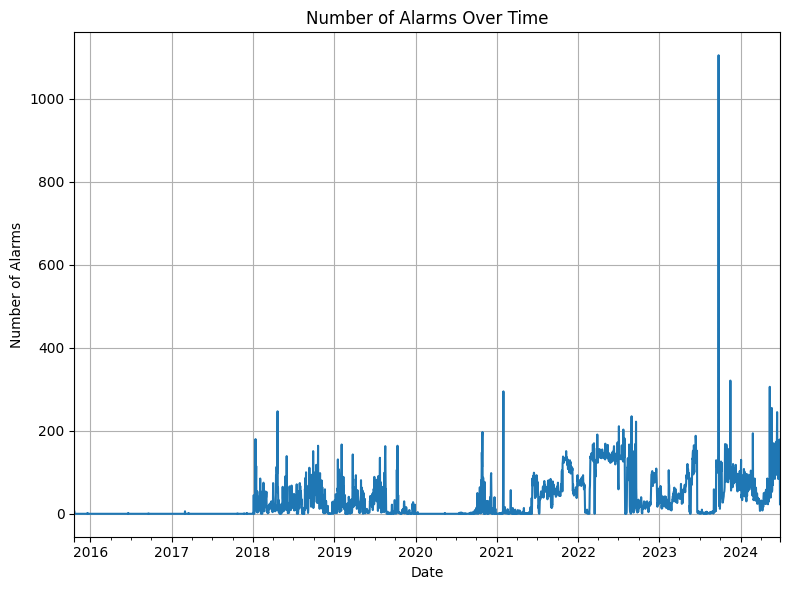

In [13]:
#| fig-cap: Number of Alarms Over Time
#| label: fig-alarms-over-time

# Plot the number of alarms over time
plt.figure(figsize=(8, 6))
daily_alarms.plot()
plt.title('Number of Alarms Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Alarms')
plt.grid(True)
plt.tight_layout()
plt.show()

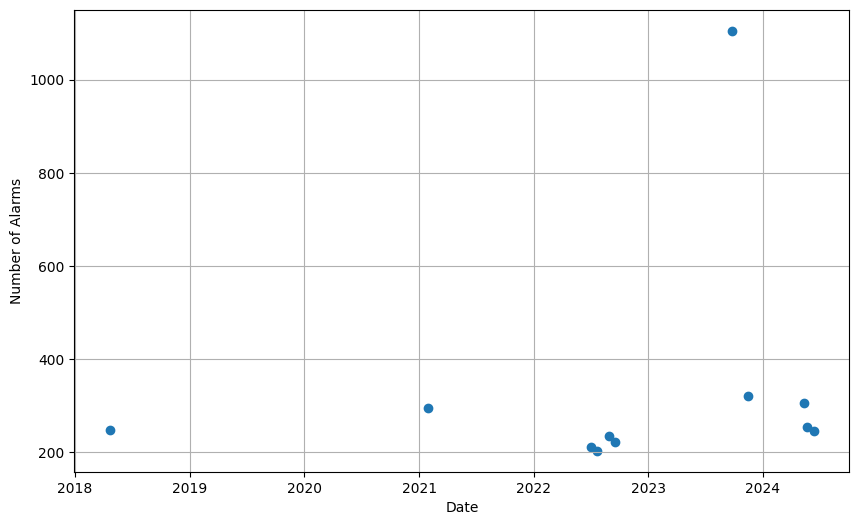

In [14]:
#| fig-cap: Number of Alarms exceeding 200 per Day
#| label: fig-alarms-exceeding-200

high_frequent_daily_alarms= daily_alarms[daily_alarms > 200]
plt.figure(figsize=(10, 6))
plt.scatter(high_frequent_daily_alarms.index, high_frequent_daily_alarms.values)
plt.xlabel('Date')
plt.ylabel('Number of Alarms')
plt.grid(True)

In [ ]:
# Cut values to 300
#daily_alarms = daily_alarms.clip(upper=300)

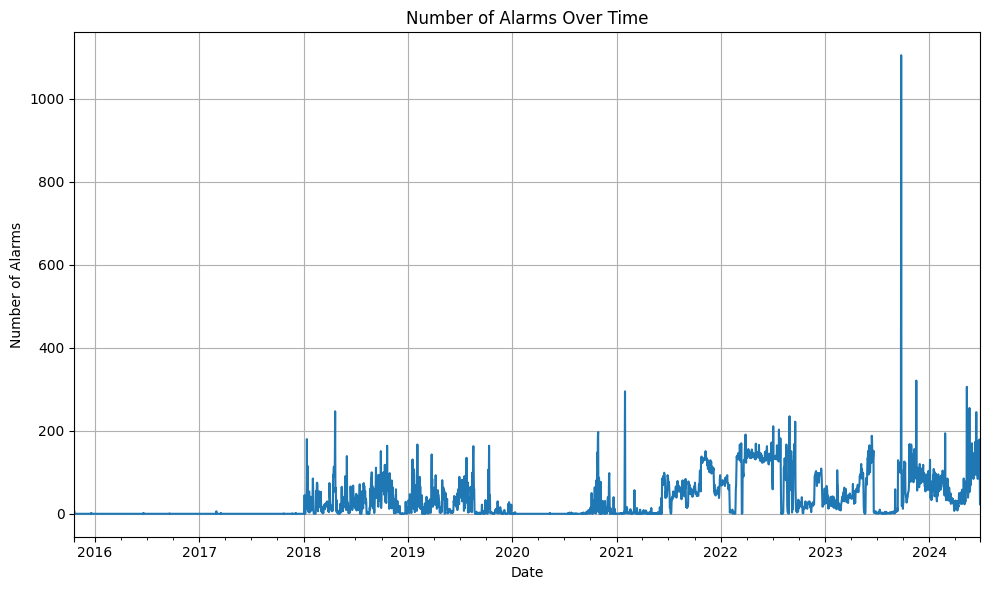

In [16]:

# Plot the number of alarms over time
plt.figure(figsize=(10, 6))
daily_alarms.plot()
plt.title('Number of Alarms Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Alarms')
plt.grid(True)
plt.tight_layout()
plt.show()

## Seasonal-Trend decomposition
STL (Seasonal-Trend decomposition using LOESS) [@stl], which separates the series into a smooth long‑term trend, a repeating seasonal component, and a residual. In this case, the trend indicates a steady increase in daily alarm counts over time, while the seasonal component shows no strong recurring pattern. @fig-categorical-counts shows higher alarm counts in summer than in winter, but this seasonal difference does not appear as a strong periodic signal in the STL plot. The residuals capture irregular fluctuations beyond trend and seasonality, and their variability appears to grow over time.

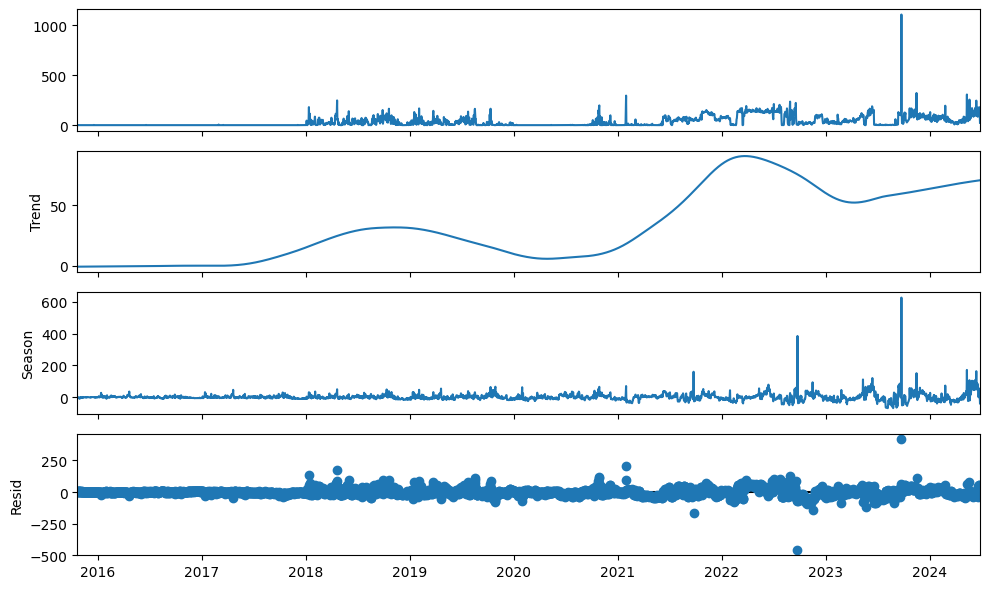

In [17]:
#| fig-cap: STL Decomposition of Daily Alarms
#| label: fig-stl-decomposition

# STL Decomposition

from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Initialize STL decomposition with a yearly period (365 days)
stl = STL(daily_alarms, period=365)

# Fit the model
result = stl.fit()

# Plot the decomposition components
fig = result.plot()
fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

## Stationarity 
In time series analysis, it is important for the time series to be stationary.
The KPSS  test is a statistical test for stationarity.

- Null hypothesis: the series is stationary (trend‑stationary). 
- Alternative: the series is non‑stationary. 

So a small p‑value suggests non‑stationarity, while a large p‑value means you fail to reject stationarity.

The KPSS test of the *daily_alarms* indicates that the differenced series is stationary. The p‑value is 0.1, which is above the 0.05 significance threshold, so we fail to reject the null hypothesis of stationarity and proceed under the assumption that the differenced series is stationary.

In [18]:
from statsmodels.tsa.stattools import kpss

# KPSS test
kpss_stat, p_value, lags, critical_values = kpss(daily_alarms.diff().dropna(), regression='c')

print(f"KPSS Statistic:, {kpss_stat:.4f}")
print("p-value:", p_value)
print("The series is stationary." if p_value > 0.05 else "The series is non-stationary.")

KPSS Statistic:, 0.0229
p-value: 0.1
The series is stationary.


/tmp/ipython-input-2372233810.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(daily_alarms.diff().dropna(), regression='c')


## ACF and PACF
@fig-acf-pacf presents the ACF and PACF of the differenced daily alarm time series.  The ACF shows significant correlations at the first two lags, while the PACF is significant only at the initial lags and then decays, which is characteristic for a MA-process. Overall, this pattern suggests only short‑term dependencies in the data.

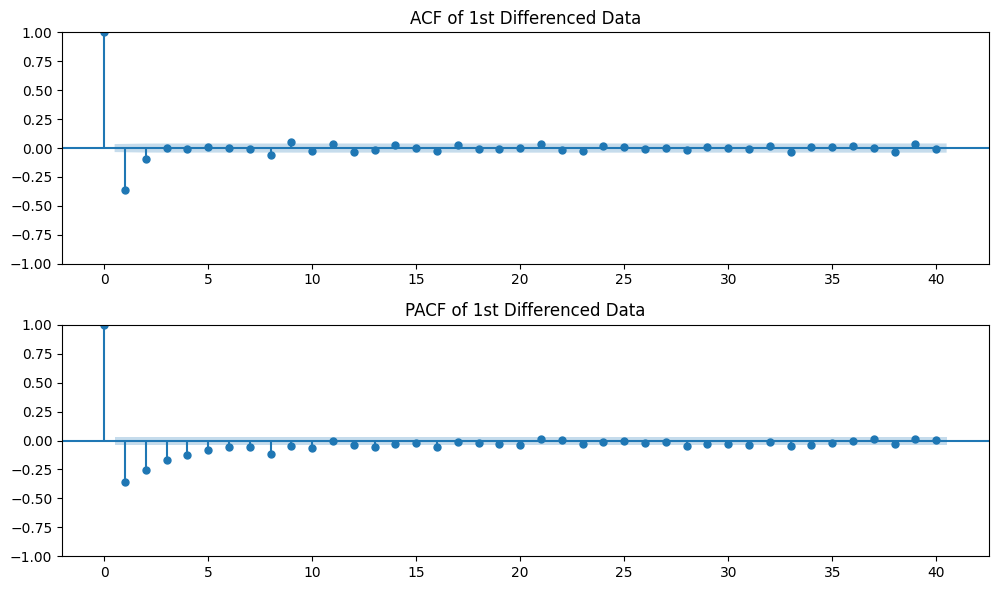

In [19]:
#| fig-cap: ACF and PACF of Differenced Daily Alarms
#| label: fig-acf-pacf

# ACF and PACF Plots


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Apply first-order differencing to the time series to remove trend/seasonality
daily_alarms_diff = daily_alarms.diff().dropna()

# Create a figure with two subplots
fig, axes = plt.subplots(2,1, figsize=(10, 6))

# Plot ACF of the differenced data
plot_acf(daily_alarms_diff, lags=40, ax=axes[0], title='ACF of 1st Differenced Data')

# Plot PACF of the differenced data
plot_pacf(daily_alarms_diff, lags=40, ax=axes[1], title='PACF of 1st Differenced Data')

plt.tight_layout()
plt.show()

## Power Spectral Density

@fig-psd-periodogram illustrates the power spectral density of the differenced daily alarm time series across multiple zoom levels of the x-axis. The spectrum is shown on a period scale (the inverse of frequency), so a 7‑day period corresponds to a weekly cycle. The plot does not show clear *weekly*, *monthly*, or *yearly* cycles. The plot concentrates more power at shorter periods, but it does not show clear peaks that would indicate strong periodic behavior. 

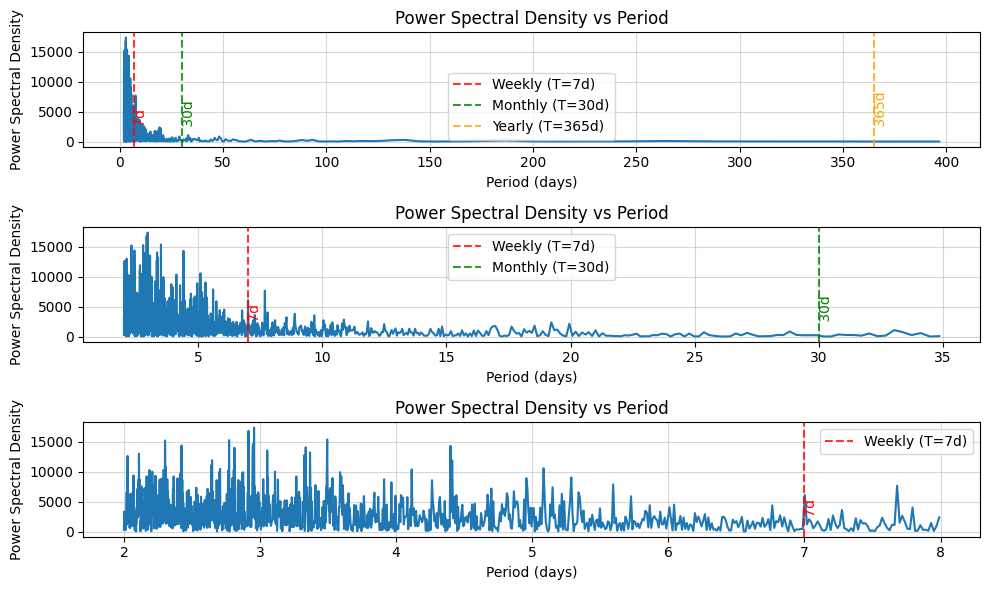

In [20]:
#| fig-cap: Power spectral density of the differenced daily alarm time series at multiple zoom levels of the period axis.
#| label: fig-psd-periodogram

# Power Spectral Density Analysis


from scipy.signal import periodogram
import matplotlib.pyplot as plt

data_for_psd = daily_alarms.diff().fillna(0)

# Periodogram (1 sample per day)
frequencies, spectrum = periodogram(data_for_psd, fs=1.0)

mask = frequencies > 0
periods = 1 / frequencies[mask]
spectrum = spectrum[mask]

periods0 = periods
spectrum0 = spectrum

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
max_periods = [400, 35, 8]
target_periods = {"Weekly": 7, "Monthly": 30, "Yearly": 365}
colors = ["red", "green", "orange"]

for ax, max_period in zip(axes, max_periods):
  period_mask = periods0 <= max_period
  periods = periods0[period_mask]
  spectrum = spectrum0[period_mask]

  # Plot
  #plt.semilogy(periods, spectrum)
  ax.plot(periods, spectrum)
  ax.set_title("Power Spectral Density vs Period")
  ax.set_xlabel("Period (days)")
  ax.set_ylabel("Power Spectral Density")
  ax.grid(True, which="both", alpha=0.5)
  #plt.xscale('log')

  for (label, period), color in zip(target_periods.items(), colors):
      if period <= max_period:
          ax.axvline(period, color=color, linestyle="--", alpha=0.8, label=f"{label} (T={period}d)")
          ax.text(period, spectrum.max() * 0.1, f" {period}d",
                  rotation=90, color=color, va="bottom")

  ax.legend()
plt.tight_layout()
plt.show()


## Grouping

Although the dataset includes an *AlarmClassName* variable that groups alarms, it is highly imbalanced. To obtain a more informative categorical representation, we introduce a new variable, *AlarmGroup*, derived from ProcessedMessage. The *ProcessedMessage* column contains 86 unique values. To use this information as a categorical feature, alarms are grouped based on semantic meaning and severity, resulting in 14 distinct alarm groups. This grouping was performed manually rather than via automated clustering. Meaningful alarm categorization requires domain knowledge.

@fig-alarm-groups shows the distribution of alarms across the defined groups. The most frequent group is *device offline* (53,061 occurrences), followed by *temperature*-related alarms. *Gas* alarms occur less frequently, but they may be safety-critical. The *trouble* group occurs 1,246 times; however, its exact operational meaning cannot be determined with certainty from the available information.



In [21]:
import re

def categorize_alarms(message: str) -> str:
    # --- normalize (light) ---
    msg = str(message).lower()
    msg = re.sub(r"\bvav[a-z0-9]+\b", " ", msg)   # remove device ids like vavj0900029
    msg = re.sub(r"\b\d+\b", " ", msg)            # remove numeric codes
    msg = re.sub(r"\s+", " ", msg).strip()

    if "gas" in msg:
        if any(k in msg for k in ["high", "emergency"]):
            return "Gas Alarm High"
        if any(k in msg for k in ["medium", "low"]):
            return "Gas Alarm Low"
        return "Gas Alarm"

    if "offline" in msg:
        return "Device Offline"
    if "space temp" in msg or "space temperature" in msg:
        return "Space Temperature"
    if "temperature" in msg and "high" in msg:
        return "Temperature High"
    if "temperature" in msg or "temp" in msg:
        return "Temperature General"
    if "set point" in msg or "setpoint" in msg:
        return "Setpoint"
    if "fan" in msg:
        return "Fan"
    if "unknown" in msg:
        return "Unknown"
    if "trouble" in msg:
        return "Trouble"
    if "fcu" in msg:
        return "FCU Alarm"

    if "alarm" in msg:
        return "Other Alarm"
    return "Other"

data['AlarmGroup'] = data['ProcessedMessage'].map(categorize_alarms)


(np.float64(11.351378160315516), np.float64(123011.89162049614))

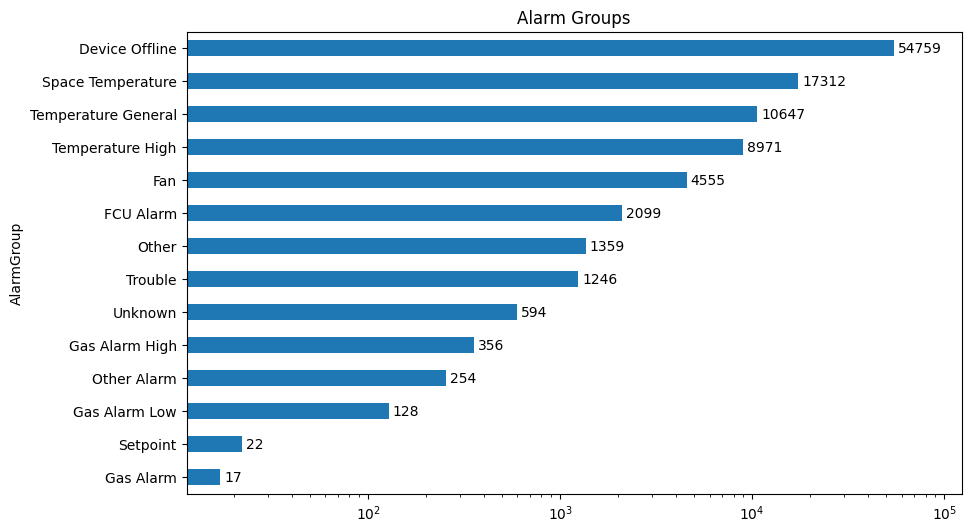

In [22]:
#| fig-cap: Alarm Groups 
#| label: fig-alarm-groups

# 1. Sort and Plot
ax = data['AlarmGroup'].value_counts().sort_values(ascending=True).plot(
    kind='barh', 
    figsize=(10,6), 
    title='Alarm Groups', 
    logx=True  # Keeps the logarithmic scale for the x-axis
)

# 2. Add the numbers (labels) to each bar
ax.bar_label(ax.containers[0], padding=3)
ax.set_xlim(right=ax.get_xlim()[1] * 1.5)


In [23]:
data['AlarmClassName'].value_counts().reset_index(name='Count')

,AlarmClassName,Count
0,General-ELV,79584
1,General-ELV-High,18214
2,LifeSafety,2321
3,Security,1348
4,CPMS,319
5,Central Battery System,309
6,Meter Alarm,104
7,SLA,78
8,Central Battery System-High,42


In [24]:
data['AssetID'].nunique()

1604

The dataset contains 1,604 unique *AssetID* values, which is too many for a categorical variable. We considered grouping by keeping the top 10 assets and combining the remainder into *other*. @fig-asset-groups shows the asset counts. Even after grouping, *AssetID* remains highly imbalanced, so to keep the feature set small we drop this variable.

In [25]:
# Categorize AssetIDs basedon frequency
# Keep top 10 frequent AssetIDs, rest as 'Other'
asset_counts = data['AssetID'].value_counts()
def categorize_asset(asset_id):
    if asset_counts[asset_id] >= asset_counts.nlargest(10).min():
        return asset_id
    return 'Other'
data['AssetGroup'] = data['AssetID'].map(categorize_asset)

(0.0, 77390.775)

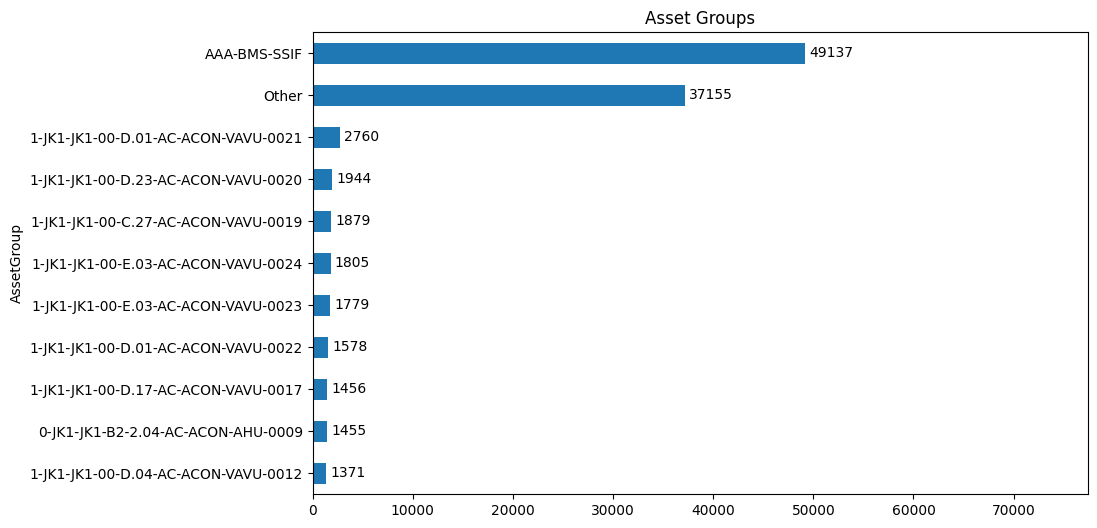

In [26]:
#| fig-cap: Asset Groups
#| label: fig-asset-groups

# Plot Asset Groups
ax = data['AssetGroup'].value_counts().sort_values(ascending=True).plot(
    kind='barh', 
    figsize=(10,6), 
    title='Asset Groups', 
)

# 2. Add the numbers (labels) to each bar
ax.bar_label(ax.containers[0], padding=3)
ax.set_xlim(right=ax.get_xlim()[1] * 1.5)

## One-Hot Encoding
Categorical features are one-hot encoded, including *AlarmSeverityName, State, Stage, AlarmClassName, DayOfWeek, Season*, and *AlarmGroup*. In addition, calendar-based time features (*Year, Month, and Day*) are added as numerical variables. @tbl-exog-feature-categories summarizes the number of features per category. After one-hot encoding, the exogenous feature set contains 52 variables. We apply a one-step lag to exogenous variables, i.e., we predict the next day's alarm count using the previous time step’s exogenous inputs. Time-derived calendar features such as *Year, Month, Day, DayOfWeek*, and *Season* are not lagged.


In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(daily_alarms) * 0.8)
train, test = daily_alarms.iloc[:train_size], daily_alarms.iloc[train_size:]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")

Training set size: 2537
Test set size: 635


In [29]:
# Build exogenous features from raw data (daily counts by category)
exog_cols = ['AlarmSeverityName', 'State', 'Stage', 'AlarmClassName', 'DayOfWeek', 'Season', 'AlarmGroup']
exog_base = data[exog_cols].copy()
exog_dummies = pd.get_dummies(exog_base, drop_first=False)
exog_daily = exog_dummies.resample('D').sum()

# Use lagged exog so tomorrow's prediction only needs today's known values
exog = exog_daily.shift(1).fillna(0)

In [30]:
exog['Year'] = exog.index.year
exog['Month'] = exog.index.month
exog['Day'] = exog.index.day
exog.shape

(3172, 52)

In [34]:
#| tbl-cap: Number of Exogenous Features by Category
#| label: tbl-exog-feature-categories
# Show exogenous feature columns grouped by their categories and the number of variables created for each.
from collections import defaultdict
category_counts = defaultdict(int)
for col in exog.columns:
    category = col.split('_')[0]  # Get the base category name
    category_counts[category] += 1
    
pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Category'})

,Category,Count
0,AlarmSeverityName,7
1,State,3
2,Stage,7
3,AlarmClassName,9
4,DayOfWeek,7
5,Season,2
6,AlarmGroup,14
7,Year,1
8,Month,1
9,Day,1


In [31]:
# Train/test split 
exog_train = exog.iloc[:train_size]
exog_test = exog.iloc[train_size:]

exog_train.shape, exog_test.shape, test.shape

((2537, 52), (635, 52), (635,))

# Results {#sec-results}

We perform time series forecasting using a supervised learning framework in which future values are predicted based on historical observations. The raw data are first aggregated to a daily frequency. The forecasting horizon is one day ahead, meaning the model predicts the value at day $(t + 1)$ using information available up to day $(t)$.

Model performance is assessed with time series cross‑validation, which respects temporal order. The data are split into multiple sequential folds; each fold trains on earlier observations and evaluates on a later 365‑day hold‑out window. RMSE is used as the evaluation metric to penalize larger prediction errors more strongly, which is particularly important for accurately capturing sharp spikes in the time series.


In [35]:
# Time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, gap=0, test_size=365)

## Baseline Model

As a baseline, we use a  model that predicts the alarm count of the next day using the observed value from the previous day. Formally, let $y_t$ denote the alarm count at day $t$. The baseline forecast is defined as

$$
\hat{y}_{t+1} = y_t .
$$

Using time-series cross-validation, we compute the RMSE for each fold as well as the average RMSE across all folds.

In [38]:
rmse_scores = []

y_pred_baseline = daily_alarms.shift(1)


for _, test_index in tscv.split(daily_alarms):
    y_test = daily_alarms.iloc[test_index]
    y_pred = y_pred_baseline.iloc[test_index]
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 19.14
Fold 2: 26.47
Fold 3: 16.59
Fold 4: 28.31
Fold 5: 81.82
Average RMSE: 34.47


## SARIMAX
Based on the KPSS test results reported above, first‑order differencing is sufficient to achieve stationarity; therefore we set $d = 1$.

A common method for selecting the AR and MA orders is to inspect the autocorrelation function ACF and partial autocorrelation function PACF plots. @fig-acf-pacf shows a sharp cutoff after two lags in the ACF and a decay in the PACF, indicating the differenced time series follows an MA(2) process.


A plausible non-seasonal configuration is $(p, d, q) = (0, 1, 2)$. As no clear seasonal pattern is observed, the seasonal component is omitted by setting $(P, D, Q) = (0, 0, 0)$.

### Alarms
We first fit a SARIMAX model without exogenous variables. @fig-arimax-actual-vs-predicted1 presents the time series cross-validation results for this model. For each fold, the predicted values are plotted against the corresponding observed values. For clarity, we display only the test folds (one year per fold) rather than the full time-series history, which allows a more detailed comparison between predicted and actual values. The same procedure is applied to all other models.

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit SARIMAX 
arimax_order = (0, 1, 2)

In [245]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

all_preds = pd.Series(index=daily_alarms.index, dtype=float)
rmse_scores = []
arimax_models = []

for fold, (train_index, test_index) in enumerate(tscv.split(daily_alarms), start=1):
    y_train = daily_alarms.iloc[train_index]
    y_test  = daily_alarms.iloc[test_index]

    # Fit on train
    res = SARIMAX(
        y_train,
        order=arimax_order,   # e.g. (0,1,2)
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    arimax_models.append(res)

    cur = res
    fold_preds = []

    # Walk-forward 1-step predictions
    for y_i in y_test:
        y_hat = cur.forecast(steps=1).iloc[0]
        fold_preds.append(y_hat)
        cur = cur.append([y_i], refit=False)

    # Store predictions aligned to original index
    all_preds.iloc[test_index] = fold_preds

    # RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_test, fold_preds))
    rmse_scores.append(rmse)

average_rmse = float(np.mean(rmse_scores))

print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 17.41
Fold 2: 24.03
Fold 3: 18.82
Fold 4: 29.46
Fold 5: 70.92
Average RMSE: 32.13


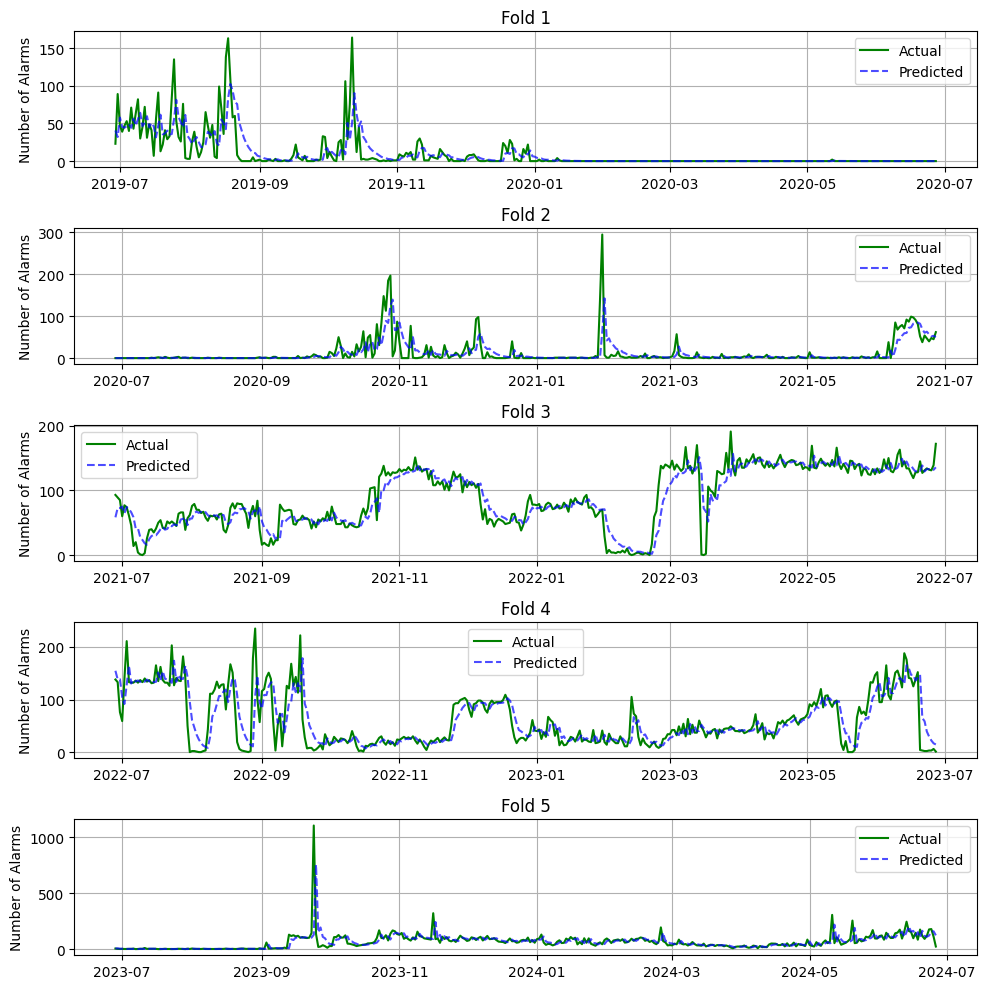

In [246]:
#| fig-cap: SARIMAX Actual vs Predicted for All Folds - only Daily Alarms
#| label: fig-arimax-actual-vs-predicted1

n_splits = tscv.get_n_splits()
fig, axes = plt.subplots(nrows=n_splits,ncols=1,figsize=(10, 2 * n_splits), sharex=False)

# Handle single-split case
if n_splits == 1:
    axes = [axes]

for fold, ((train_index, test_index), ax) in enumerate(zip(tscv.split(daily_alarms), axes),start=1):
    y_test = daily_alarms.iloc[test_index]
    y_pred = all_preds.iloc[test_index]
    ax.plot(y_test.index, y_test.values,label="Actual", color="green")
    ax.plot( y_test.index, y_pred.values, label="Predicted", color="blue", alpha=0.7, linestyle="--")

    ax.set_title(f"Fold {fold}")
    ax.set_ylabel("Number of Alarms")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [247]:
# # Fit final SARIMAX model on full training data only with daily alarms
# arimax_model = SARIMAX(train, order=arimax_order, enforce_stationarity=False, enforce_invertibility=False)
# arimax_result = arimax_model.fit(disp=False)


In [248]:
# # Forecast differenced values, then invert the differencing
# alarm_forecast = arimax_result.forecast(steps=len(test))
# arimax_forecast = pd.Series(alarm_forecast, index=test.index).clip(lower=0)

# # Evaluate
# arimax_rmse = np.sqrt(mean_squared_error(test, arimax_forecast))
# print(f"RMSE: {arimax_rmse:.2f}")
# print(f"MAE: {mean_absolute_error(test, arimax_forecast):.2f}")

In [249]:
# #| fig-cap: ARIMAX Forecast vs Actuals on Test Set - Daily Alarms
# #| label: fig-arimax-forecast-vs-actuals1

# # Plot train, test, and ARIMAX forecast
# plt.figure(figsize=(10, 6))
# plt.plot(test.index, test, label='Test', color='green')
# plt.plot(arimax_forecast.index, arimax_forecast, label='ARIMAX Forecast', color='blue', linestyle='--', alpha=0.7)
# plt.title('ARIMAX Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('Number of Alarms')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### Alarms with Exogenous Variables
Next, we fit a SARIMAX model with all exogenous variables from @tbl-exog-feature-categories. @fig-arimax-actual-vs-predicted2 shows the time series cross-validation results. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

rmse_scores = []
arimax_models = []

# store all predictions aligned to original index
all_preds = pd.Series(index=daily_alarms.index, dtype=float)

for fold, (train_index, test_index) in enumerate(tscv.split(daily_alarms), start=1):
    y_train = daily_alarms.iloc[train_index]
    y_test  = daily_alarms.iloc[test_index]

    X_train = exog.iloc[train_index]
    X_test  = exog.iloc[test_index]

    # Fit on training data
    res = SARIMAX(
        y_train,
        exog=X_train,
        order=arimax_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    arimax_models.append(res)

    cur = res
    fold_preds = []

    # Walk-forward 1-step-ahead predictions
    for i in range(len(y_test)):
        y_hat = cur.forecast(
            steps=1,
            exog=X_test.iloc[[i]]   # must be 2D
        ).iloc[0]

        fold_preds.append(max(0, y_hat))  # clip lower=0 safely

        # update state with observed value + exog
        cur = cur.append(
            endog=[y_test.iloc[i]],
            exog=X_test.iloc[[i]],
            refit=False
        )

    # store predictions aligned to original index
    all_preds.iloc[test_index] = fold_preds

    rmse = np.sqrt(mean_squared_error(y_test, fold_preds))
    rmse_scores.append(rmse)

average_rmse = float(np.mean(rmse_scores))




In [251]:
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 17.92
Fold 2: 49.96
Fold 3: 51.15
Fold 4: 30.04
Fold 5: 93.68
Average RMSE: 48.55


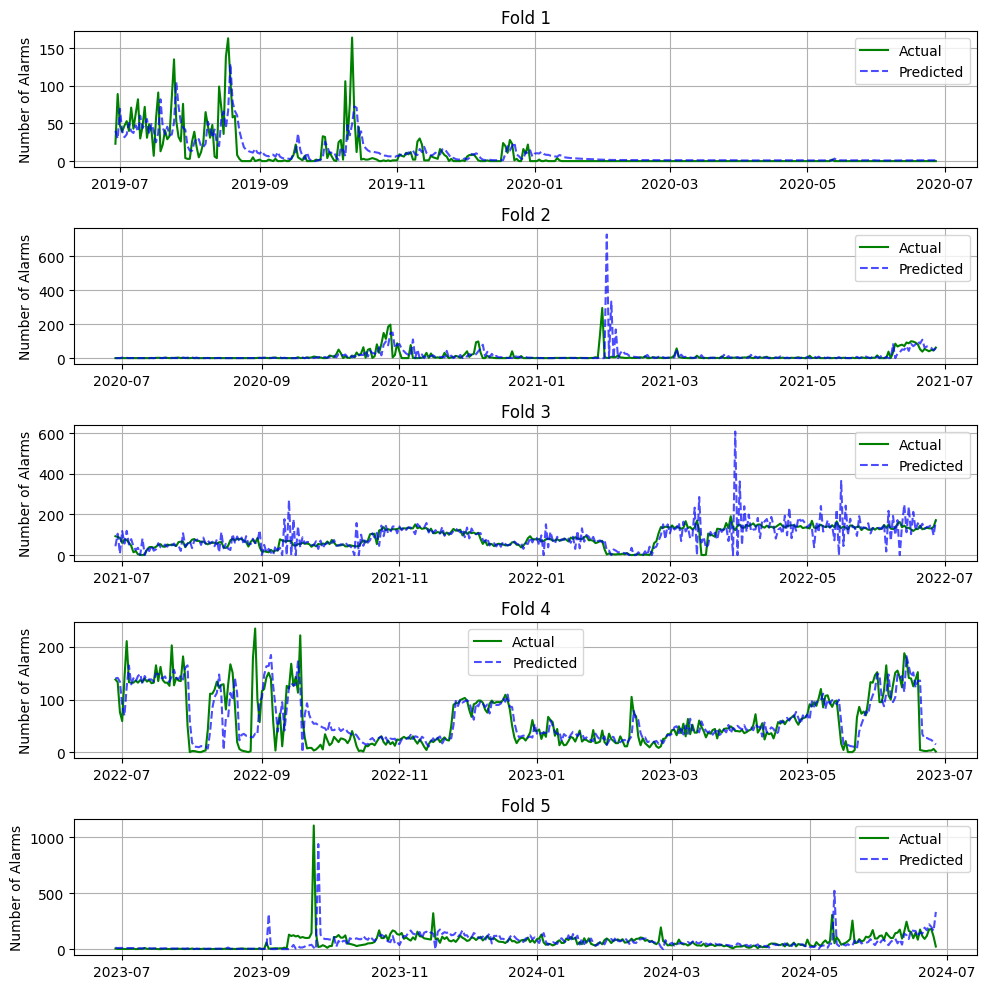

In [252]:
#| fig-cap: SARIMAX Actual vs Predicted for All Folds with Exogenous Variables
#| label: fig-arimax-actual-vs-predicted2

n_splits = tscv.get_n_splits()
fig, axes = plt.subplots(nrows=n_splits,ncols=1,figsize=(10, 2 * n_splits), sharex=False)

# Handle single-split case
if n_splits == 1:
    axes = [axes]

for fold, ((train_index, test_index), ax) in enumerate(zip(tscv.split(daily_alarms), axes),start=1):
    y_test = daily_alarms.iloc[test_index]
    y_pred = all_preds.iloc[test_index]
    ax.plot(y_test.index, y_test.values,label="Actual", color="green")
    ax.plot( y_test.index, y_pred.values, label="Predicted", color="blue", alpha=0.7, linestyle="--")

    ax.set_title(f"Fold {fold}")
    ax.set_ylabel("Number of Alarms")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [253]:

# Fit ARIMAX (ARMA on differenced data)
arimax_model = SARIMAX(train, order=arimax_order, exog=exog_train,
                        enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)


/Users/ThomasStockl/Documents/Study/Gitportfolio/gpt/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [254]:
# # Forecast differenced values, then invert the differencing
# alarm_forecast = arimax_result.forecast(steps=len(test), exog=exog_test)
# arimax_forecast = pd.Series(alarm_forecast, index=test.index).clip(lower=0)

# # Evaluate
# arimax_rmse = np.sqrt(mean_squared_error(test, arimax_forecast))
# print(f"RMSE: {arimax_rmse:.2f}")
# print(f"MAE: {mean_absolute_error(test, arimax_forecast):.2f}")

In [255]:
# #| fig-cap: ARIMAX Forecast vs Actuals on Test Set - with Exogenous Variables
# #| label: fig-arimax-forecast-vs-actuals2

# # Plot train, test, and ARIMAX forecast
# plt.figure(figsize=(10, 6))
# plt.plot(test.index, test, label='Test', color='green')
# plt.plot(arimax_forecast.index, arimax_forecast, label='ARIMAX Forecast', color='blue', linestyle='--', alpha=0.7)
# plt.title('ARIMAX Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('Number of Alarms')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [256]:
train_idx_sel = next(tscv.split(exog))[0]
exog_sel = exog.iloc[train_idx_sel]
daily_alarm_sec = daily_alarms.iloc[train_idx_sel]


In [257]:
def fit_aic(y, X=None):
    model = SARIMAX(y, exog=X, order=arimax_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res.aic, res

def forward_select_aic(y, X, max_features=None, tol=1e-5):
    remaining = list(X.columns)
    selected = []
    best_aic, best_res = fit_aic(y, X=None)

    if max_features is None:
        max_features = len(remaining)

    while remaining and len(selected) < max_features:
        trials = []
        for f in remaining:
            cand = selected + [f]
            aic, _ = fit_aic(y, X[cand])
            trials.append((aic, f))

        trials.sort(key=lambda t: t[0])
        cand_aic, best_f = trials[0]

        if cand_aic < best_aic - tol:
            selected.append(best_f)
            remaining.remove(best_f)
            best_aic, best_res = fit_aic(y, X[selected])
            print(f"Added {best_f:>20s} | AIC: {best_aic:.3f}")
        else:
            break

    return selected, best_aic, best_res
        

In [258]:
# best_exog_sarimax =  forward_select_aic(daily_alarm_sec, exog_sel, 10)

### Alarms with selected Exogenous Variables
To reduce dimensionality, we select only the most relevant exogenous variables using forward selection based on the Akaike Information Criterion (AIC). Model performance is evaluated using time series cross-validation, where the first four folds are used for validation during model selection and the final fold is used as a test set. The selected variables are *AlarmSeverityName*, *State*, *DayOfWeek*, and *AlarmClassName*. This reduced set comprises 26 features, compared to the original 52. @fig-arimax-actual-vs-predicted3 shows the time-series cross-validation results of the model using the selected exogenous variables.


In [259]:
# use subset of features which contains the name
selected_exog_cols = [col for col in exog.columns if any(cat in col for cat in ['AlarmSeverityName', 'State', 'DayOfWeek', 'AlarmClassName'])]
selected_exog_cols

['AlarmSeverityName_1 - High',
 'AlarmSeverityName_2 - Medium',
 'AlarmSeverityName_3 - Low',
 'AlarmSeverityName_BACnet',
 'AlarmSeverityName_CPMS',
 'AlarmSeverityName_Central Battery System-Medium',
 'AlarmSeverityName_Meter',
 'State_A2A',
 'State_A2N',
 'State_N2A',
 'AlarmClassName_CPMS',
 'AlarmClassName_Central Battery System',
 'AlarmClassName_Central Battery System-High',
 'AlarmClassName_General-ELV',
 'AlarmClassName_General-ELV-High',
 'AlarmClassName_LifeSafety',
 'AlarmClassName_Meter Alarm',
 'AlarmClassName_SLA',
 'AlarmClassName_Security',
 'DayOfWeek_Friday',
 'DayOfWeek_Monday',
 'DayOfWeek_Saturday',
 'DayOfWeek_Sunday',
 'DayOfWeek_Thursday',
 'DayOfWeek_Tuesday',
 'DayOfWeek_Wednesday']

In [260]:
exog_train_subset = exog[selected_exog_cols]
exog_test_subset = exog[selected_exog_cols]

In [261]:
rmse_scores = []
arimax_models = []

# store predictions aligned to original index
all_preds = pd.Series(index=daily_alarms.index, dtype=float)

for fold, (train_index, test_index) in enumerate(tscv.split(daily_alarms), start=1):
    y_train = daily_alarms.iloc[train_index]
    y_test  = daily_alarms.iloc[test_index]

    X_train = exog_train_subset.iloc[train_index]
    X_test  = exog_train_subset.iloc[test_index]

    # Fit model on training data
    res = SARIMAX(
        y_train,
        exog=X_train,
        order=arimax_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    arimax_models.append(res)

    cur = res
    fold_preds = []

    # Walk-forward 1-step-ahead predictions
    for i in range(len(y_test)):
        y_hat = cur.forecast(
            steps=1,
            exog=X_test.iloc[[i]]   # must be 2D
        ).iloc[0]

        fold_preds.append(max(0, y_hat))  # clip lower bound safely

        cur = cur.append(
            endog=[y_test.iloc[i]],
            exog=X_test.iloc[[i]],
            refit=False
        )

    # Store predictions aligned to full index
    all_preds.iloc[test_index] = fold_preds

    rmse = np.sqrt(mean_squared_error(y_test, fold_preds))
    rmse_scores.append(rmse)

average_rmse = float(np.mean(rmse_scores))

/Users/ThomasStockl/Documents/Study/Gitportfolio/gpt/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ThomasStockl/Documents/Study/Gitportfolio/gpt/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ThomasStockl/Documents/Study/Gitportfolio/gpt/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ThomasStockl/Documents/Study/Gitportfolio/gpt/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

In [262]:
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 17.43
Fold 2: 24.52
Fold 3: 19.61
Fold 4: 30.25
Fold 5: 68.40
Average RMSE: 32.04


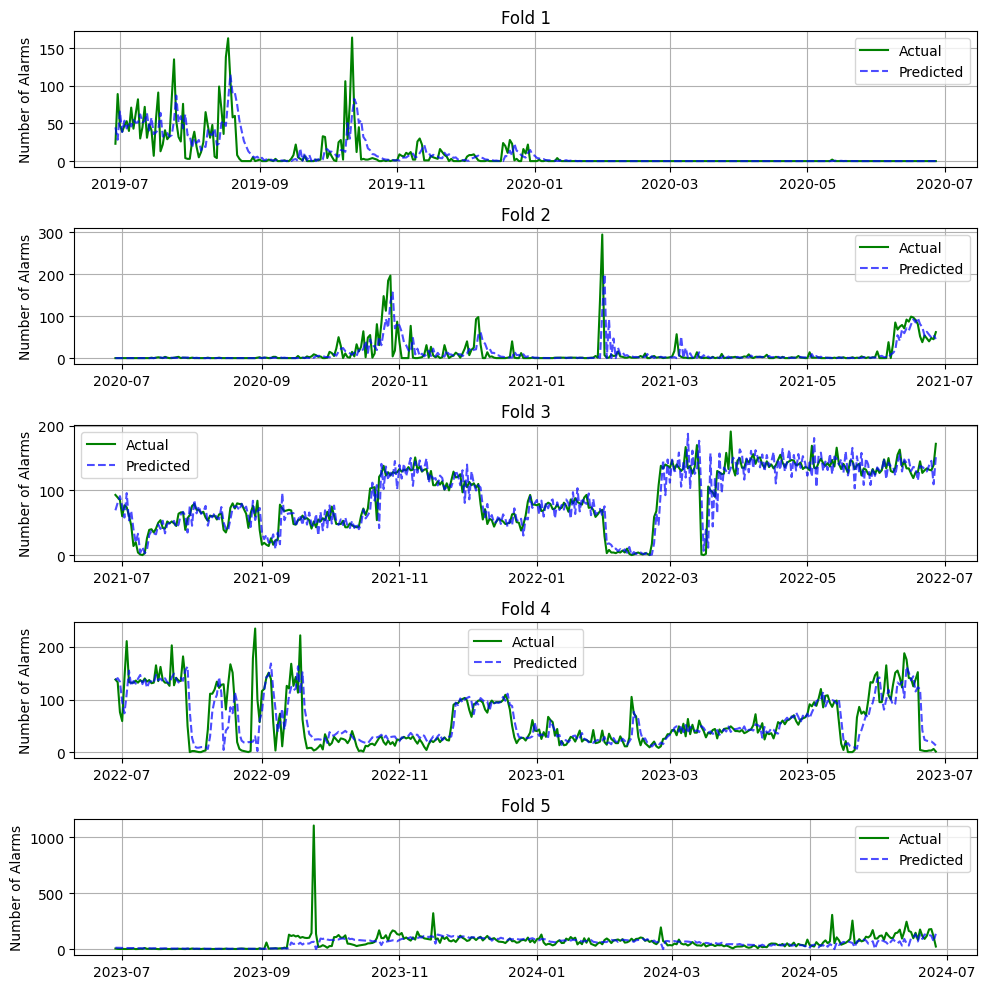

In [263]:
#| fig-cap: SARIMAX Actual vs Predicted for All Folds - Selected Exogenous Features
#| label: fig-arimax-actual-vs-predicted3

#| fig-cap: SARIMAX Actual vs Predicted for All Folds with Exogenous Variables
#| label: fig-arimax-actual-vs-predicted2

n_splits = tscv.get_n_splits()
fig, axes = plt.subplots(nrows=n_splits,ncols=1,figsize=(10, 2 * n_splits), sharex=False)

# Handle single-split case
if n_splits == 1:
    axes = [axes]

for fold, ((train_index, test_index), ax) in enumerate(zip(tscv.split(daily_alarms), axes),start=1):
    y_test = daily_alarms.iloc[test_index]
    y_pred = all_preds.iloc[test_index]
    ax.plot(y_test.index, y_test.values,label="Actual", color="green")
    ax.plot( y_test.index, y_pred.values, label="Predicted", color="blue", alpha=0.7, linestyle="--")

    ax.set_title(f"Fold {fold}")
    ax.set_ylabel("Number of Alarms")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [151]:

# Fit ARIMAX 
# arimax_model = SARIMAX(train, order=arimax_order, exog=exog_train_subset,
#                         enforce_stationarity=False, enforce_invertibility=False)
# arimax_result = arimax_model.fit(disp=False)


In [51]:
# # Forecast differenced values, then invert the differencing
# alarm_forecast = arimax_result.forecast(steps=len(test), exog=exog_test_subset)
# arimax_forecast = pd.Series(alarm_forecast, index=test.index).clip(lower=0)

# # Evaluate
# arimax_rmse = np.sqrt(mean_squared_error(test, arimax_forecast))
# print(f"RMSE: {arimax_rmse:.2f}")
# print(f"MAE: {mean_absolute_error(test, arimax_forecast):.2f}")

In [52]:
# #| fig-cap: ARIMAX Forecast vs Actuals on Test Set - with Selected Exogenous Features
# #| label: fig-arimax-forecast-vs-actuals3

# # Plot train, test, and ARIMAX forecast
# plt.figure(figsize=(10, 6))
# plt.plot(test.index, test, label='Test', color='green')
# plt.plot(arimax_forecast.index, arimax_forecast, label='ARIMAX Forecast', color='blue', linestyle='--', alpha=0.7)
# plt.title('ARIMAX Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('Number of Alarms')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

\subsection*{Conclusion}
The SARIMAX model without exogenous variables performs slightly better than the baseline model. However, adding all exogenous variables worsens the results because it introduces additional noise. Using only the selected variables gives the best overall performance. Nevertheless, the model still lags behind the true values, especially when sharp spikes occur.

## XGBoost

For this model, additional lagged features of the daily alarm series are included as input variables, covering lags from one to seven days. This means that the model can learn from the past alarm counts to make predictions for the current day.

@fig-xgb-actual-vs-predicted shows the time series cross-validation results of the XGB Regressor model with exogenous variables and lagged features.



In [40]:
# XGB Regressor model for time series forecasting with exogenous variables
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare features and target variable
X = exog
y = daily_alarms

# Create lag alarms as features
for lag in range(1, 8):  # 1 to 7 days lag
    X[f'lag_{lag}'] = y.shift(lag)


X.bfill(inplace=True)
y.head()
X.head()

,AlarmSeverityName_1 - High,AlarmSeverityName_2 - Medium,AlarmSeverityName_3 - Low,AlarmSeverityName_BACnet,AlarmSeverityName_CPMS,AlarmSeverityName_Central Battery System-Medium,AlarmSeverityName_Meter,State_A2A,State_A2N,State_N2A,...,Year,Month,Day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2015,10,21,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2015-10-22,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,2015,10,22,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2015-10-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2015,10,23,0.0,5.0,5.0,5.0,5.0,5.0,5.0
2015-10-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2015,10,24,0.0,0.0,5.0,5.0,5.0,5.0,5.0
2015-10-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2015,10,25,0.0,0.0,0.0,5.0,5.0,5.0,5.0


In [268]:
# X, X_test_final = X.iloc[:train_size], X.iloc[train_size:]
# y, y_test_final = y.iloc[:train_size], y.iloc[train_size:]

In [55]:
# X.shape, y.shape, X_test_final.shape, y_test_final.shape

In [ ]:
from sklearn.inspection import permutation_importance

# Time series cross-validation
rmse_scores = []
xgb_models = []
all_importances = []


for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and fit the model
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, SEED=1)
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    xgb_models.append(xgb_model)

    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    
    # Permutation Importance
    result = permutation_importance(
        xgb_model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=1,
        scoring="neg_mean_absolute_error"  # or any relevant metric
    )
    all_importances.append(result.importances_mean)
    
    
# Print average RMSE across folds
average_rmse = np.mean(rmse_scores)


In [ ]:
# import numpy as np
# from pathlib import Path
# from joblib import dump

# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor
# from sklearn.inspection import permutation_importance

# # -------------------------
# # helpers
# # -------------------------
# def rmse(y_true, y_pred):
#     return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# # -------------------------
# # 0) materialize your 5 splits
# # -------------------------
# splits = list(tscv.split(X))
# assert len(splits) == 5, f"Expected 5 splits, got {len(splits)}"

# cv_splits = splits[:-1]   # first 4 splits for hyperparam selection
# test_split = splits[-1]   # last split for final testing

# # -------------------------
# # 1) "recommended" XGBoost search space (common, strong defaults)
# #    (tune breadth depends on time budget)
# # -------------------------
# param_grid = {
#     # boosting dynamics
#     "learning_rate": [0.01, 0.03, 0.05, 0.1],
#     "max_depth": [3, 4, 5, 6, 8],
#     "min_child_weight": [1, 3, 5, 10],
#     "gamma": [0.0, 0.1, 0.2],  # min split loss

#     # sampling (regularization / generalization)
#     "subsample": [0.7, 0.85, 1.0],
#     "colsample_bytree": [0.7, 0.85, 1.0],

#     # L1/L2 regularization
#     "reg_alpha": [0.0, 1e-3, 1e-2, 1e-1, 1.0],
#     "reg_lambda": [1.0, 3.0, 5.0, 10.0],
# }

# # Global fixed params (recommended defaults)
# fixed_params = dict(
#     objective="reg:squarederror",
#     n_estimators=2000,      # high, because we'll use early stopping
#     random_state=1,
#     n_jobs=-1,
#     tree_method="hist",     # fast + usually good
# )

# # -------------------------
# # 2) hyperparameter search on first 4 splits
# #    - evaluate mean CV RMSE (lower is better)
# # -------------------------
# best_score = np.inf
# best_params = None

# for params in ParameterGrid(param_grid):
#     fold_scores = []
#     for fold_id, (train_idx, val_idx) in enumerate(cv_splits, start=1):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = XGBRegressor(**fixed_params, **params)
#         model.fit(
#             X_train, y_train,
#             eval_set=[(X_val, y_val)],
#             verbose=False,
#             early_stopping_rounds=100,
#         )

#         y_hat = model.predict(X_val)
#         fold_scores.append(rmse(y_val, y_hat))

#     mean_score = float(np.mean(fold_scores))

#     if mean_score < best_score:
#         best_score = mean_score
#         best_params = params

# print("Best mean CV RMSE (first 4 splits):", best_score)
# print("Best params:", best_params)

# # -------------------------
# # 3) fit + SAVE the best model for EACH of the first 4 folds
# # -------------------------
# out_dir = Path("xgb_time_series_models")
# out_dir.mkdir(parents=True, exist_ok=True)

# best_fold_models = []
# best_fold_metrics = []

# for fold_id, (train_idx, val_idx) in enumerate(cv_splits, start=1):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     model = XGBRegressor(**fixed_params, **best_params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=False,
#         early_stopping_rounds=100,
#     )

#     y_hat = model.predict(X_val)
#     fold_rmse = rmse(y_val, y_hat)

#     best_fold_models.append(model)
#     best_fold_metrics.append({"fold": fold_id})

#     # Save (pickle) – easiest to reload and predict with sklearn API
#     dump(model, out_dir / f"xgb_bestparams_fold{fold_id}.joblib")

#     # Optional: also save native XGBoost format (portable)
#     model.save_model(out_dir / f"xgb_bestparams_fold{fold_id}.json")

# print("\nPer-fold metrics (best params):")
# for m in best_fold_metrics:
#     print(m)

# print(f"\nSaved {len(best_fold_models)} fold models to: {out_dir.resolve()}")

# # -------------------------
# # 4) final training on ALL data up to last split, then TEST on last split
# # -------------------------
# train_idx_final, test_idx = test_split
# X_train_final, X_test = X.iloc[train_idx_final], X.iloc[test_idx]
# y_train_final, y_test = y.iloc[train_idx_final], y.iloc[test_idx]

# final_model = XGBRegressor(**fixed_params, **best_params)
# final_model.fit(
#     X_train_final, y_train_final,
#     eval_set=[(X_test, y_test)],          # ok for monitoring; do not early-stop on test if you want purity
#     verbose=False,
#     # early_stopping_rounds=100,          # keep OFF if you want test to be fully untouched
# )

# y_test_pred = final_model.predict(X_test)
# test_rmse = rmse(y_test, y_test_pred)

# print("\nFINAL TEST (last split only)")
# print("Test RMSE:", test_rmse)

# dump(final_model, out_dir / "xgb_final_train_upto_lastsplit.joblib")
# final_model.save_model(out_dir / "xgb_final_train_upto_lastsplit.json")

# # -------------------------
# # 5) permutation importance on true test split (optional)
# # -------------------------
# perm = permutation_importance(
#     final_model,
#     X_test,
#     y_test,
#     n_repeats=10,
#     random_state=1,
#     scoring="neg_mean_absolute_error",
#     n_jobs=-1,
# )

# importances = perm.importances_mean
# rank_idx = np.argsort(importances)[::-1]
# print("\nTop 20 features by permutation importance:")
# for i in rank_idx[:20]:
#     print(f"{X_test.columns[i]}: {importances[i]:.6f}")


In [42]:
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 18.67
Fold 2: 25.70
Fold 3: 29.40
Fold 4: 29.04
Fold 5: 74.68
Average RMSE: 35.50


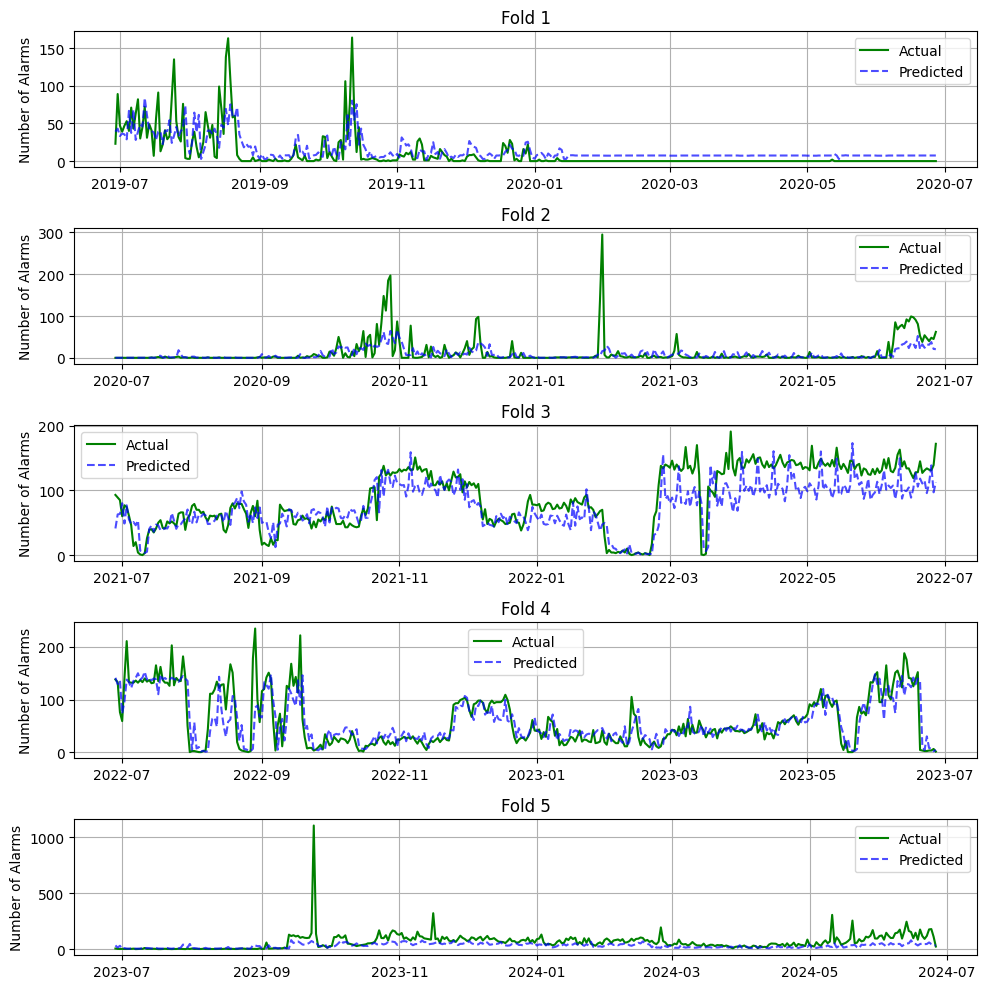

In [271]:
#| fig-cap: XGB Regressor Actual vs Predicted for All Folds
#| label: fig-xgb-actual-vs-predicted

# Plot Actual vs Predicted for all folds
fig, axes = plt.subplots(nrows=tscv.get_n_splits(), ncols=1, figsize=(10, 2 * tscv.get_n_splits()))

for fold, ((train_index, test_index), ax, xgb_model) in enumerate(zip(tscv.split(X), axes, xgb_models), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    
    ax.plot(y_test.index, y_test, label='Actual', color='green')
    ax.plot(y_test.index, y_pred, label='Predicted', color='blue', alpha=0.7, linestyle='--')
    ax.set_title(f'Fold {fold}')
    ax.set_ylabel('Number of Alarms')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()  

In [59]:
mean_importance = np.mean(all_importances, axis=0)
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": mean_importance
}).sort_values("importance", ascending=False)


The XGBoost model underperforms compared to the SARIMAX models; however, it is still able to capture the general trend and variability in the alarm counts.

The permutation feature importance indicates how much each feature contributes to the model's predictive performance. @fig-xgb-feature-importance shows the feature importance of the Top 20 XGB Regressor model. The most important features are Stage_Cancelled, AlarmClassName_General-ELV, followed by lagged alarm count features.

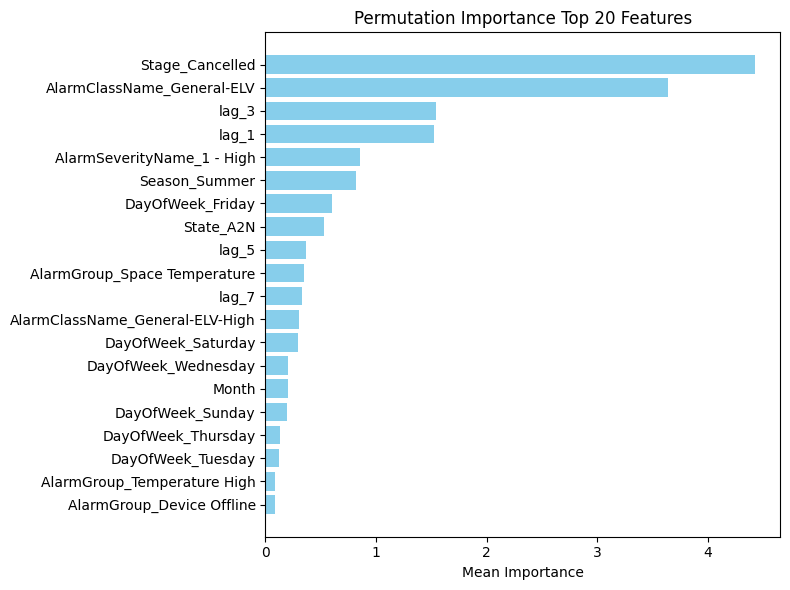

In [60]:
#| fig-cap: XGB Regressor Feature Importance
#| label: fig-xgb-feature-importance

importance_df_top10 = importance_df.head(20)

# Feature importance plot
plt.figure(figsize=(8,6))
plt.barh(importance_df_top10['feature'], importance_df_top10['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Permutation Importance Top 20 Features")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()



In [61]:
# # Train final model on entire training set and evaluate on final test set
# X_train, y_train = X, y

# xgb_model.fit(X_train, y_train, verbose=False)
# y_pred = xgb_model.predict(X_test_final)

In [62]:
# # Actual vs Predicted plot for final test set

# # mask = (y_test.index >= '2022-07-01') & (y_test.index <= '2022-08-30')
# # X_test = X_test.loc[mask]
# # y_test = y_test.loc[mask]

# plt.figure(figsize=(10, 6))
# plt.plot(y_test_final.index, y_test_final, label='Actual', color='green')
# plt.plot(y_test_final.index, y_pred, label='Predicted', color='blue', alpha=0.7, linestyle='--')
# plt.title(f'Fold {fold}: Actual vs Predicted')
# plt.xlabel('Date')
# plt.ylabel('Number of Alarms')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [63]:
# # Print average RMSE for final test set
# final_rmse = np.sqrt(mean_squared_error(y_test_final, y_pred))
# print(f'Final Test Set RMSE: {final_rmse:.2f}')

## RNN
For the RNN, we use a fixed lookback window of the past days of all variables to predict the alarm count of the next day. The model consists of a recurrent layer with a ReLU activation, followed by dropout and a linear output layer. The hyperparameters include the *lookback window*, *batch size*, and *learning rate*, as well as recurrent-model parameters such as *hidden size* and the *number of layers*. Models are trained for up to 200 epochs with early stopping based on validation performance. Model performance is evaluated using time series cross-validation, where the first four folds are used for validation during model selection and the final fold is used as a test set. The hyperparameters are tuned over the following ranges:

- Lookback window: $1$–$20$
- Batch size: $16, 32, 64, 128$
- Hidden size: $1$–$32$
- Number of layers: $1$–$3$
- Learning rate: $0.01$–$0.0001$



In [32]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import copy
from sklearn.preprocessing import StandardScaler
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
import os, random
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(SEED)

In [48]:
#General Parameters
EPOCHS = 50
PATIENCE = 6
best_val = float('inf')
patience_left = PATIENCE
best_state = None
criterion = nn.MSELoss()
HORIZON = 1  # set >1 for multi-step output

In [35]:
class WindowedDataset(Dataset):
    def __init__(self, X, y, lookback, horizon):
        self.X = X
        self.y = y
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon + 1

    def __getitem__(self, idx):
        x = self.X[idx:idx + self.lookback]
        y = self.y[idx + self.lookback - 1: idx + self.lookback + self.horizon - 1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [36]:
daily_alarms.name = "AlarmCount"
exog_with_alarms = pd.concat([daily_alarms.shift().fillna(0),exog], axis=1)

In [62]:
def create_datasets(lookback=7, batch_size= 16, only_alarm=True):
    train_loader_list = []
    val_loader_list = []

    x_scalers = []  # keep one scaler per fold (still “one scaler” per fold)

    for train_idx, test_idx in tscv.split(daily_alarms):
        if only_alarm:
            X = daily_alarms.shift().fillna(0)
            X_train_df = X.iloc[train_idx].to_frame()
            X_val_df   = X.iloc[test_idx].to_frame()
            
        else:
            X_train_df = exog_with_alarms.iloc[train_idx]
            X_val_df   = exog_with_alarms.iloc[test_idx]

        y_train = daily_alarms.iloc[train_idx].astype(float)
        y_val   = daily_alarms.iloc[test_idx].astype(float)

        y_train = (y_train).to_numpy()
        y_val   = (y_val).to_numpy()
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_df)
        X_val   = scaler.transform(X_val_df)

        train_ds = WindowedDataset(X_train, y_train, lookback, HORIZON)
        val_ds   = WindowedDataset(X_val, y_val, lookback, HORIZON)

        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True
        )

        train_loader_list.append(train_loader)
        val_loader_list.append(val_loader)
        x_scalers.append(scaler)
    return train_loader_list, val_loader_list, x_scalers, X_train.shape[1]



In [63]:
class RNNForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=8, num_layers=1, horizon=1):
        super().__init__()
        self.rnn = nn.RNN(n_features, hidden_size, num_layers, batch_first=True, nonlinearity="relu")
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(hidden_size, horizon)

    def forward(self, x):
        out, _ = self.rnn(x)          # (batch, seq_len, hidden_size)
        out = out[:, -1, :]           # last timestep
        out = self.dropout(out)
        out = self.head(out)
        return out


In [64]:

# --- model ---
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=8, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(hidden_size, horizon)
        

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.dropout(out)
        out = self.head(out)
        return out

In [65]:
# Model Parameters
def init_model(n_feaetures, hidden_size=4, num_layers=1, learning_rate= 1e-3, model_type="rnn"):
    n_features = n_feaetures
    if model_type == "rnn":
        model = RNNForecaster(n_features, hidden_size=hidden_size, num_layers=num_layers, horizon=HORIZON)
    elif model_type == "lstm": 
        model = LSTMForecaster(n_features, hidden_size=hidden_size, num_layers=num_layers, horizon=HORIZON)
    model = model.to(device)
    init_state = copy.deepcopy(model.state_dict())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model, init_state, optimizer

In [66]:
def train_model(model, init_state, init_optimizer, train_loader_list, val_loader_list, verbose=False):
    rmse_scores = []
    rnn_models = []
    device = next(model.parameters()).device  # infer device
    for fold_idx, (train_loader, val_loader) in enumerate(zip(train_loader_list, val_loader_list)):
        best_val = float('inf')
        best_state = None
        patience_left = PATIENCE

        model.load_state_dict(init_state)  # reset weights

        # reset optimizer state per fold to avoid leakage
        optimizer = type(init_optimizer)(model.parameters(), **init_optimizer.defaults)
        optimizer.load_state_dict(init_optimizer.state_dict())

        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0.0

            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * xb.size(0)

            train_loss = total_loss / len(train_loader.dataset)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    yb = yb.to(device)

                    preds = model(xb)
                    loss = criterion(preds, yb)
                    val_loss += loss.item() * xb.size(0)

            val_loss = val_loss / len(val_loader.dataset)

            if (epoch + 1) % 5 == 0 and verbose:
                print(f'Fold {fold_idx+1} - Epoch {epoch+1}/{EPOCHS} - train: {train_loss:.4f} - val: {val_loss:.4f}')

            if val_loss < best_val:
                best_val = val_loss
                best_state = copy.deepcopy(model.state_dict())
                patience_left = PATIENCE
            else:
                patience_left -= 1
                if patience_left == 0:
                    if verbose: 
                        print('Early stopping triggered')
                    break

        if best_state is not None:
            model.load_state_dict(best_state)

        # --- evaluation (RMSE on original scale) ---
        model.eval()
        all_preds = []
        all_true = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                preds = model(xb)
                all_preds.append(preds.detach().cpu().numpy())
                all_true.append(yb.detach().cpu().numpy())

        preds = np.vstack(all_preds)
        true = np.vstack(all_true)

        rmse = np.sqrt(np.mean((preds - true) ** 2))
        rmse_scores.append(rmse)
        rnn_models.append(best_state)
        
    return rnn_models, rmse_scores


In [42]:
!pip install optuna

In [59]:
best_model_params = {
    "rnn": {"rmse_val": np.inf},
    "lstm": {"rmse_val": np.inf},
}

In [ ]:
# import pickle

# with open("best_model_params3.pkl", "rb") as f:
#     best_model_params = pickle.load(f)

# best_model_params


{'rnn': {'rmse_val': np.float32(34.580635),
  'rmse_total': np.float32(44.483376),
  'rmse_scores': [np.float32(19.694382),
   np.float32(27.349283),
   np.float32(42.298065),
   np.float32(48.980812),
   np.float32(84.09433)],
  'model_states': [OrderedDict([('rnn.weight_ih_l0',
                 tensor([[-0.3142, -0.0680,  0.1156,  0.2296, -0.1506,  0.0122, -0.2627,  0.1971,
                           0.5861,  0.5003, -0.4154,  0.2676,  0.3032, -0.4143,  0.0816, -0.0317,
                           0.4657, -0.3684, -0.4438,  0.3524, -0.2421, -0.0804,  0.0621, -0.0109,
                           0.1301, -0.3866,  0.5683,  0.5562,  0.5775,  0.5097,  0.3532,  0.0264,
                          -0.1717,  0.4074, -0.0248, -0.5146,  0.4135, -0.4375,  0.0273,  0.1682,
                           0.1523,  0.1996,  0.3137, -0.2502,  0.0811, -0.3004, -0.2798,  0.3099,
                          -0.1927, -0.0912, -0.2376,  0.2049],
                         [-0.1979, -0.3292, -0.2041,  0.1638, -0.296

In [67]:
import optuna

def objective(trial, model_type, verbose=False):
    lookback = trial.suggest_int("lookback", 1, 128, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    hidden_size = trial.suggest_int("hidden_size", 2, 32, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 1e-2, log=True)

    train_loader_list, val_loader_list, _, n_features = create_datasets(
        lookback=lookback, batch_size=batch_size
    )
    model, init_state, optimizer = init_model(
        n_features, hidden_size=hidden_size, num_layers=num_layers,
        learning_rate=learning_rate, model_type=model_type
    )
    models, rmse_scores = train_model(
        model, init_state, optimizer, train_loader_list, val_loader_list, verbose
    )

    rmse_total = np.average(rmse_scores)
    average_val_scores = np.average(rmse_scores[:-1])
    
    best = best_model_params[model_type]

    if average_val_scores < best["rmse_val"]:
        best_model_params[model_type] = {
            "rmse_val": average_val_scores,
            "rmse_total": rmse_total,
            "rmse_scores": copy.deepcopy(rmse_scores),
            "model_states": copy.deepcopy(models),
            "model": copy.deepcopy(model),
            "val_loader_list": copy.deepcopy(val_loader_list),
            "trial_params": copy.deepcopy(trial.params),
    }

    return average_val_scores


In [61]:
from functools import partial
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(partial(objective, model_type="rnn",verbose=True), n_trials=38)

print("Best:", study.best_params, study.best_value)
#41 minutes for 50 trials T4 GPU
# 20 minutes for 32 trial A100 GPU

[I 2026-01-30 01:41:14,570] A new study created in memory with name: no-name-fca73878-c0bc-432e-818e-4a7bb98aeb57


Fold 1 - Epoch 5/50 - train: 516.8595 - val: 401.9994
Fold 1 - Epoch 10/50 - train: 365.6147 - val: 367.2539
Fold 1 - Epoch 15/50 - train: 364.5626 - val: 367.4950
Fold 1 - Epoch 20/50 - train: 354.6416 - val: 372.2386
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 403.8612 - val: 814.0295
Fold 2 - Epoch 10/50 - train: 387.2710 - val: 781.5851
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 450.7345 - val: 8964.8466
Fold 3 - Epoch 10/50 - train: 460.8472 - val: 8381.5104
Fold 3 - Epoch 15/50 - train: 408.9554 - val: 7637.3983
Fold 3 - Epoch 20/50 - train: 438.8150 - val: 7160.9024
Fold 3 - Epoch 25/50 - train: 406.2828 - val: 6493.1699
Fold 3 - Epoch 30/50 - train: 395.4124 - val: 5826.0810
Fold 3 - Epoch 35/50 - train: 385.7325 - val: 5345.8001
Fold 3 - Epoch 40/50 - train: 385.5022 - val: 4951.4696
Fold 3 - Epoch 45/50 - train: 372.5149 - val: 4708.9482
Fold 3 - Epoch 50/50 - train: 385.3852 - val: 4399.5000
Fold 4 - Epoch 5/50 - train: 763.4280 - val: 180271.1981
Early 

[I 2026-01-30 01:41:41,347] Trial 0 finished with value: 47.681663513183594 and parameters: {'lookback': 5, 'batch_size': 16, 'hidden_size': 2, 'num_layers': 1, 'learning_rate': 0.0014078451062457585}. Best is trial 0 with value: 47.681663513183594.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 674.6525 - val: 635.6577
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 340.1235 - val: 904.2006
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 426.9189 - val: 6965.1398
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 2056.0802 - val: 4656.2593
Fold 4 - Epoch 10/50 - train: 1069.1155 - val: 220162.9553
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 1413.7446 - val: 7410.1734


[I 2026-01-30 01:41:46,329] Trial 1 finished with value: 43.492515563964844 and parameters: {'lookback': 4, 'batch_size': 64, 'hidden_size': 75, 'num_layers': 1, 'learning_rate': 0.00372621874449789}. Best is trial 1 with value: 43.492515563964844.


Fold 5 - Epoch 10/50 - train: 1324.2914 - val: 93146.2862
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 689.0635 - val: 651.4395
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 395.8473 - val: 1292.7587
Fold 2 - Epoch 10/50 - train: 394.9903 - val: 851.8076
Fold 2 - Epoch 15/50 - train: 324.9785 - val: 913.3482
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 457.7314 - val: 4370.0792
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 2099.5540 - val: 3423.9715
Fold 4 - Epoch 10/50 - train: 1887.9429 - val: 28277.8156
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 1710.5171 - val: 52876.4235
Fold 5 - Epoch 10/50 - train: 2135.4841 - val: 11494.9507


[I 2026-01-30 01:41:50,259] Trial 2 finished with value: 47.06556701660156 and parameters: {'lookback': 5, 'batch_size': 128, 'hidden_size': 112, 'num_layers': 1, 'learning_rate': 0.003978345474386764}. Best is trial 1 with value: 43.492515563964844.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 358.8305 - val: 495.4962
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 327.2994 - val: 2725.3706
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 405.8112 - val: 3656.1772
Fold 3 - Epoch 10/50 - train: 329.5335 - val: 2860.3108
Fold 3 - Epoch 15/50 - train: 300.6131 - val: 2562.5515
Fold 3 - Epoch 20/50 - train: 265.5038 - val: 2746.3057
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 607.4407 - val: 5541.5736
Fold 4 - Epoch 10/50 - train: 563.6645 - val: 41293.9447
Fold 4 - Epoch 15/50 - train: 805.1350 - val: 4922.7560
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 681.3613 - val: 459271.1441


[I 2026-01-30 01:42:10,140] Trial 3 finished with value: 40.682586669921875 and parameters: {'lookback': 9, 'batch_size': 16, 'hidden_size': 75, 'num_layers': 1, 'learning_rate': 0.0017654021691542545}. Best is trial 3 with value: 40.682586669921875.


Fold 5 - Epoch 10/50 - train: 551.6656 - val: 682707.1838
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 457.2624 - val: 587.5435
Fold 1 - Epoch 10/50 - train: 624.3266 - val: 506.6889
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 593.6050 - val: 72352.6910
Fold 2 - Epoch 10/50 - train: 413.2632 - val: 2667.6800
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 335.7888 - val: 8664.0820
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 1800.7445 - val: 34112.6395
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 742.8971 - val: 83239.8572


[I 2026-01-30 01:42:17,911] Trial 4 finished with value: 49.13154602050781 and parameters: {'lookback': 10, 'batch_size': 32, 'hidden_size': 62, 'num_layers': 1, 'learning_rate': 0.004730752844325125}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 643.5459 - val: 547.2078
Fold 1 - Epoch 10/50 - train: 364.6387 - val: 495.5269
Fold 1 - Epoch 15/50 - train: 360.7664 - val: 513.0611
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 465.5825 - val: 1219.1366
Fold 2 - Epoch 10/50 - train: 385.9374 - val: 997.1977
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 459.9287 - val: 4829.5259
Fold 3 - Epoch 10/50 - train: 426.2368 - val: 5404.5101
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 1213.5831 - val: 6230.4073
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 850.9770 - val: 52728.1478


[I 2026-01-30 01:42:23,937] Trial 5 finished with value: 43.546424865722656 and parameters: {'lookback': 10, 'batch_size': 64, 'hidden_size': 11, 'num_layers': 3, 'learning_rate': 0.0012049549733080752}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 758.8807 - val: 683.5937
Fold 1 - Epoch 10/50 - train: 741.9199 - val: 666.4510
Fold 1 - Epoch 15/50 - train: 658.3563 - val: 573.6537
Fold 1 - Epoch 20/50 - train: 418.2166 - val: 353.4834
Fold 1 - Epoch 25/50 - train: 364.2212 - val: 320.5072
Fold 1 - Epoch 30/50 - train: 367.7977 - val: 321.7353
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 747.7160 - val: 795.6044
Fold 2 - Epoch 10/50 - train: 712.4870 - val: 736.4166
Fold 2 - Epoch 15/50 - train: 491.9202 - val: 651.4222
Fold 2 - Epoch 20/50 - train: 375.7971 - val: 877.2099
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 754.9944 - val: 7776.0073
Fold 3 - Epoch 10/50 - train: 693.2602 - val: 6897.1770
Fold 3 - Epoch 15/50 - train: 425.1938 - val: 5349.1163
Fold 3 - Epoch 20/50 - train: 412.8469 - val: 5634.7643
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 2110.6304 - val: 4361.6837
Fold 4 - Epoch 10/50 - train: 1966.1881 - val: 3699.8628
Fold 4 - Epoch 1

[I 2026-01-30 01:42:33,854] Trial 6 finished with value: 46.441680908203125 and parameters: {'lookback': 3, 'batch_size': 64, 'hidden_size': 5, 'num_layers': 2, 'learning_rate': 0.0005866732359998499}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 416.8159 - val: 404.9568
Fold 1 - Epoch 10/50 - train: 390.0608 - val: 382.6705
Fold 1 - Epoch 15/50 - train: 367.1901 - val: 385.5238
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 443.4068 - val: 1020.3011
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 453.2350 - val: 5908.1155
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 675.5858 - val: 32203.4708
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 802.0098 - val: 101574.3535


[I 2026-01-30 01:42:39,570] Trial 7 finished with value: 47.80567169189453 and parameters: {'lookback': 6, 'batch_size': 64, 'hidden_size': 9, 'num_layers': 3, 'learning_rate': 0.0017291380099611875}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 700.3833 - val: 683.7500
Fold 1 - Epoch 10/50 - train: 651.7627 - val: 627.2752
Fold 1 - Epoch 15/50 - train: 508.6396 - val: 474.0662
Fold 1 - Epoch 20/50 - train: 356.6900 - val: 335.1223
Fold 1 - Epoch 25/50 - train: 331.1312 - val: 338.4538
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 719.0535 - val: 758.8596
Fold 2 - Epoch 10/50 - train: 599.5671 - val: 670.4691
Fold 2 - Epoch 15/50 - train: 367.5635 - val: 1197.4208
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 722.6389 - val: 3992.0067
Fold 3 - Epoch 10/50 - train: 532.2208 - val: 2787.1235
Fold 3 - Epoch 15/50 - train: 380.6675 - val: 1958.9108
Fold 3 - Epoch 20/50 - train: 375.0720 - val: 2257.4026
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 2012.7624 - val: 3670.0097
Fold 4 - Epoch 10/50 - train: 1535.2765 - val: 3542.3483
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 2303.9123 - val: 10599.9736


[I 2026-01-30 01:42:45,299] Trial 8 finished with value: 42.94786834716797 and parameters: {'lookback': 1, 'batch_size': 128, 'hidden_size': 20, 'num_layers': 3, 'learning_rate': 0.0007547944846482187}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 660.8429 - val: 623.1539
Fold 1 - Epoch 10/50 - train: 386.0803 - val: 371.5409
Fold 1 - Epoch 15/50 - train: 341.1695 - val: 387.3250
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 591.7937 - val: 711.4746
Fold 2 - Epoch 10/50 - train: 412.3043 - val: 894.5012
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 502.1008 - val: 2855.0814
Fold 3 - Epoch 10/50 - train: 421.5244 - val: 3581.6198
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 661.7050 - val: 4065.6829
Fold 4 - Epoch 10/50 - train: 588.1018 - val: 3348.2747
Early stopping triggered


[I 2026-01-30 01:42:49,326] Trial 9 finished with value: 46.28278350830078 and parameters: {'lookback': 2, 'batch_size': 128, 'hidden_size': 7, 'num_layers': 3, 'learning_rate': 0.004400633090109042}. Best is trial 3 with value: 40.682586669921875.


Fold 5 - Epoch 5/50 - train: 788.1307 - val: 167556.6049
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 319.4653 - val: 373.4874
Fold 1 - Epoch 10/50 - train: 317.4602 - val: 369.5455
Fold 1 - Epoch 15/50 - train: 271.8801 - val: 405.8100
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 335.1486 - val: 724.4764
Fold 2 - Epoch 10/50 - train: 264.8569 - val: 847.0390
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 308.6990 - val: 2285.1949
Fold 3 - Epoch 10/50 - train: 356.2419 - val: 3052.2396
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 385.1870 - val: 132190.1764
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 419.3375 - val: 54548.6495


[I 2026-01-30 01:43:05,387] Trial 10 finished with value: 43.64695739746094 and parameters: {'lookback': 8, 'batch_size': 16, 'hidden_size': 40, 'num_layers': 2, 'learning_rate': 0.008459781981158257}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 702.6027 - val: 647.0234
Fold 1 - Epoch 10/50 - train: 382.5738 - val: 457.4671
Fold 1 - Epoch 15/50 - train: 350.0305 - val: 445.9092
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 698.3555 - val: 770.0700
Fold 2 - Epoch 10/50 - train: 396.0100 - val: 1914.8822
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 668.4646 - val: 3195.1286
Fold 3 - Epoch 10/50 - train: 430.5518 - val: 2272.4402
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 1648.2536 - val: 74577.1753
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 1314.1999 - val: 142863.7796


[I 2026-01-30 01:43:09,519] Trial 11 finished with value: 42.96645736694336 and parameters: {'lookback': 7, 'batch_size': 128, 'hidden_size': 25, 'num_layers': 2, 'learning_rate': 0.0006535858206388349}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 334.0058 - val: 367.7732
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 338.6367 - val: 1352.3063
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 380.8834 - val: 5097.1024
Fold 3 - Epoch 10/50 - train: 354.7015 - val: 4203.3058
Fold 3 - Epoch 15/50 - train: 335.6419 - val: 3853.2589
Fold 3 - Epoch 20/50 - train: 331.8015 - val: 3729.7942
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 397.2042 - val: 4565.8566
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 437.0001 - val: 82390.6113


[I 2026-01-30 01:43:26,004] Trial 12 finished with value: 42.850746154785156 and parameters: {'lookback': 1, 'batch_size': 16, 'hidden_size': 33, 'num_layers': 2, 'learning_rate': 0.0009743763392147098}. Best is trial 3 with value: 40.682586669921875.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 332.8279 - val: 508.6465
Fold 1 - Epoch 10/50 - train: 296.7368 - val: 452.6000
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 319.1752 - val: 2034.4682
Fold 2 - Epoch 10/50 - train: 292.9122 - val: 2133.5623
Fold 2 - Epoch 15/50 - train: 266.8020 - val: 1319.6335
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 358.6047 - val: 1916.9825
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 611.1915 - val: 139919.3524
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 447.8267 - val: 17697.2862


[I 2026-01-30 01:43:43,315] Trial 13 finished with value: 93.8833999633789 and parameters: {'lookback': 8, 'batch_size': 16, 'hidden_size': 36, 'num_layers': 2, 'learning_rate': 0.0024098622568232845}. Best is trial 3 with value: 40.682586669921875.


Fold 5 - Epoch 10/50 - train: 360.0797 - val: 78165.9607
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 336.0240 - val: 350.2647
Fold 1 - Epoch 10/50 - train: 307.0174 - val: 455.2979
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 333.4313 - val: 834.2946
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 370.6638 - val: 5626.5576
Fold 3 - Epoch 10/50 - train: 357.7159 - val: 4018.9700
Fold 3 - Epoch 15/50 - train: 336.6497 - val: 3256.0629
Fold 3 - Epoch 20/50 - train: 321.9537 - val: 3275.5508
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 373.9127 - val: 4352.7901
Fold 4 - Epoch 10/50 - train: 351.8333 - val: 4125.0773
Fold 4 - Epoch 15/50 - train: 338.3526 - val: 4146.0826
Fold 4 - Epoch 20/50 - train: 328.5187 - val: 3574.0022
Fold 4 - Epoch 25/50 - train: 324.4569 - val: 3002.1720
Fold 4 - Epoch 30/50 - train: 313.1816 - val: 5269.3480
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 409.8458 - val: 40146.9482


[I 2026-01-30 01:44:05,811] Trial 14 finished with value: 39.7739372253418 and parameters: {'lookback': 1, 'batch_size': 16, 'hidden_size': 119, 'num_layers': 1, 'learning_rate': 0.0010054726264992295}. Best is trial 14 with value: 39.7739372253418.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 332.9456 - val: 541.0894
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 626.7441 - val: 685.8600
Fold 2 - Epoch 10/50 - train: 311.4041 - val: 1773.1890
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 597.4497 - val: 5780.4664
Fold 3 - Epoch 10/50 - train: 328.1054 - val: 1595.8874
Fold 3 - Epoch 15/50 - train: 279.2017 - val: 2233.6810
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 844.5336 - val: 193664.3962
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 653.9677 - val: 235720.4741


[I 2026-01-30 01:44:20,827] Trial 15 finished with value: 37.763736724853516 and parameters: {'lookback': 9, 'batch_size': 16, 'hidden_size': 125, 'num_layers': 1, 'learning_rate': 0.002092662052924503}. Best is trial 15 with value: 37.763736724853516.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 352.6882 - val: 435.4802
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 367.9854 - val: 3859.1313
Fold 2 - Epoch 10/50 - train: 357.8518 - val: 2551.4707
Fold 2 - Epoch 15/50 - train: 271.4160 - val: 1083.9840
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 359.8104 - val: 8662.0149
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 544.5680 - val: 3808.5075
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 511.3147 - val: 9709.2338


[I 2026-01-30 01:44:29,510] Trial 16 finished with value: 48.00829315185547 and parameters: {'lookback': 3, 'batch_size': 32, 'hidden_size': 119, 'num_layers': 1, 'learning_rate': 0.002684791121952473}. Best is trial 15 with value: 37.763736724853516.


Fold 5 - Epoch 10/50 - train: 508.8229 - val: 19551.0960
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 329.0805 - val: 610.1392
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 351.0213 - val: 2141.6184
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 419.4855 - val: 5490.3053
Fold 3 - Epoch 10/50 - train: 339.7547 - val: 2380.5013
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 552.1022 - val: 30254.2468
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 646.0221 - val: 106800.5685


[I 2026-01-30 01:44:43,941] Trial 17 finished with value: 57.945255279541016 and parameters: {'lookback': 6, 'batch_size': 16, 'hidden_size': 125, 'num_layers': 1, 'learning_rate': 0.0010307472601902225}. Best is trial 15 with value: 37.763736724853516.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 368.6984 - val: 631.3096
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 418.2099 - val: 2832.4056
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 434.8474 - val: 5266.3547
Fold 3 - Epoch 10/50 - train: 398.5482 - val: 3156.5676
Fold 3 - Epoch 15/50 - train: 367.3828 - val: 2329.9578
Fold 3 - Epoch 20/50 - train: 351.1347 - val: 2600.0567
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 568.8388 - val: 79897.3573
Fold 4 - Epoch 10/50 - train: 506.1223 - val: 84499.9005
Fold 4 - Epoch 15/50 - train: 469.6190 - val: 41563.7804
Fold 4 - Epoch 20/50 - train: 433.2403 - val: 9134.9726
Fold 4 - Epoch 25/50 - train: 392.9699 - val: 14075.8924
Fold 4 - Epoch 30/50 - train: 382.3471 - val: 17221.0199
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 726.8992 - val: 148311.4249
Fold 5 - Epoch 10/50 - train: 642.0447 - val: 237131.7248


[I 2026-01-30 01:45:09,306] Trial 18 finished with value: 42.14714813232422 and parameters: {'lookback': 7, 'batch_size': 16, 'hidden_size': 52, 'num_layers': 1, 'learning_rate': 0.0005070116197386744}. Best is trial 15 with value: 37.763736724853516.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 369.7935 - val: 407.5718
Fold 1 - Epoch 10/50 - train: 327.5663 - val: 632.7068
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 356.9168 - val: 1410.6936
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 424.6773 - val: 4832.4871
Fold 3 - Epoch 10/50 - train: 390.7841 - val: 3324.6814
Fold 3 - Epoch 15/50 - train: 353.7075 - val: 2244.7629
Fold 3 - Epoch 20/50 - train: 334.9015 - val: 2236.2768
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 527.0180 - val: 55339.7109
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 612.6843 - val: 45205.5527
Fold 5 - Epoch 10/50 - train: 526.2386 - val: 42510.7949
Fold 5 - Epoch 15/50 - train: 499.3099 - val: 25156.9245
Fold 5 - Epoch 20/50 - train: 452.1189 - val: 17565.5836


[I 2026-01-30 01:45:35,278] Trial 19 finished with value: 41.54002380371094 and parameters: {'lookback': 4, 'batch_size': 16, 'hidden_size': 17, 'num_layers': 2, 'learning_rate': 0.000828882323273333}. Best is trial 15 with value: 37.763736724853516.


Fold 5 - Epoch 25/50 - train: 418.5987 - val: 24005.1227
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 424.9592 - val: 549.7188
Fold 1 - Epoch 10/50 - train: 368.6964 - val: 684.0984
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 330.3314 - val: 2284.1567
Fold 2 - Epoch 10/50 - train: 313.8757 - val: 2155.9430
Early stopping triggered


[W 2026-01-30 01:45:38,990] Trial 20 failed with parameters: {'lookback': 9, 'batch_size': 32, 'hidden_size': 81, 'num_layers': 1, 'learning_rate': 0.0016776714942718994} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-3237314757.py", line 17, in objective
    models, rmse_scores = train_model(
                          ^^^^^^^^^^^^
  File "/tmp/ipython-input-289291679.py", line 27, in train_model
    loss.backward()
  File "/usr/local/lib/python3.12/dist-packages/torch/_tensor.py", line 625, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py", line 841, in _engine_run_ba

KeyboardInterrupt: 

### Alarms
We first fit a RNN model without exogenous variables. @fig-rnn-actual-vs-predicted_only_alarms presents the time series cross-validation results for this model.

In [ ]:
# {'lookback': 3,
#  'batch_size': 16,
#  'hidden_size': 18,
#  'num_layers': 3,
#  'learning_rate': 0.009859855564320655}
rmse_scores = best_model_params['rnn']['rmse_scores']
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")

RMSE per Fold:
Fold 1: 17.50
Fold 2: 22.89
Fold 3: 18.32
Fold 4: 27.22
Fold 5: 67.56
Average RMSE: 30.70


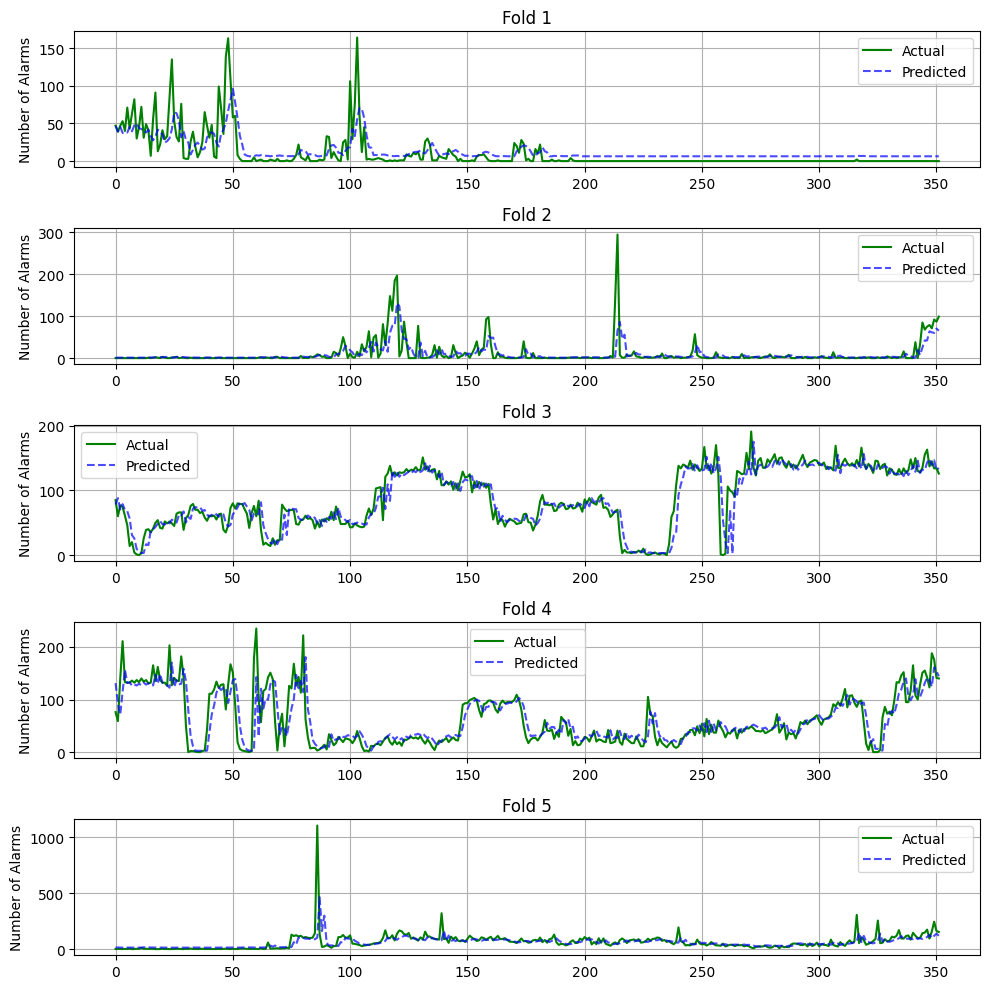

In [ ]:
#| fig-cap: RNN Actual vs Predicted for All Folds - only Daily Alarms
#| label: fig-rnn-actual-vs-predicted_only_alarms

def plot_rnn_tscv(rnn_models, rnn_model, val_loader_list):
    daily_alarms_index_list = []
    for _, test_idx in tscv.split(daily_alarms):
        daily_alarms_index_list.append(daily_alarms.index[test_idx])  

    fig, axes = plt.subplots(
        nrows=tscv.get_n_splits(),
        ncols=1,
        figsize=(10, 2 * tscv.get_n_splits())
    )

    for fold, (val_loader, ax, rnn_state, daily_alarm_index) in enumerate(
        zip(val_loader_list, axes, rnn_models, daily_alarms_index_list),
        start=1
    ):
        all_preds = []
        all_true = []

        rnn_model.load_state_dict(rnn_state)
        rnn_model.eval()

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = rnn_model(xb)
                all_preds.append(preds.detach().cpu().numpy())
                all_true.append(yb.detach().cpu().numpy())

        preds = np.vstack(all_preds)
        true = np.vstack(all_true)

        ax.plot( true, label='Actual', color='green')
        ax.plot( preds, label='Predicted', color='blue', alpha=0.7, linestyle='--')
        ax.set_title(f'Fold {fold}')
        ax.set_ylabel('Number of Alarms')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
rnn_params = best_model_params['rnn']
rnn_model = rnn_params['model']
rnn_models = rnn_params['model_states']
val_loader_list = rnn_params['val_loader_list']
plot_rnn_tscv(rnn_models, rnn_model, val_loader_list)


The optimized hyperparameters for the RNN model are:

- Lookback window: 3
- Batch size: 16
- Hidden size: 18
- Number of layers: 3
- Learning rate: $9.9 \times 10^{-3}$



### Alarms with Exogenous Variables
We fit a RNN model with all exogenous variables @fig-rnn-actual-vs-predicted shows the time series cross-validation results.

In [55]:
rmse_scores = best_model_params['rnn']['rmse_scores']
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 19.69
Fold 2: 27.35
Fold 3: 42.30
Fold 4: 48.98
Fold 5: 84.09
Average RMSE: 44.48


In [49]:
# train_loader_list, val_loader_list, _ = create_datasets(lookback=7, batch_size=16)
# rnn_model, init_state, optimizer = init_model(hidden_size=4, num_layers=1, learning_rate= 1e-3)
# rnn_models, rmse_scores = train_rnn(rnn_model, init_state, optimizer, train_loader_list, val_loader_list)
# Best: {'lookback': 5, 'batch_size': 8, 'hidden_size': 2, 'num_layers': 2, 'learning_rate': 0.007732739007126294} 29.258434295654297

#best_params = study.best_params
# train_loader_list, val_loader_list, _, n_features = create_datasets(
#     lookback=5, 
#     batch_size=32
# )
# rnn_model, init_state, optimizer = init_model(
#     n_features, 
#     hidden_size=2, 
#     num_layers=2, 
#     learning_rate=0.001,
#     model_type="rnn"
# )
# rnn_models, rmse_scores = train_model(
#     rnn_model, init_state, optimizer, train_loader_list, val_loader_list, True
# )
# print(f'RMSE scores for each fold: {[f"{score:.2f}" for score in rmse_scores]}')
# print(f'Average RMSE across folds: {np.mean(rmse_scores):.2f}')

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:733: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.rnn_relu(


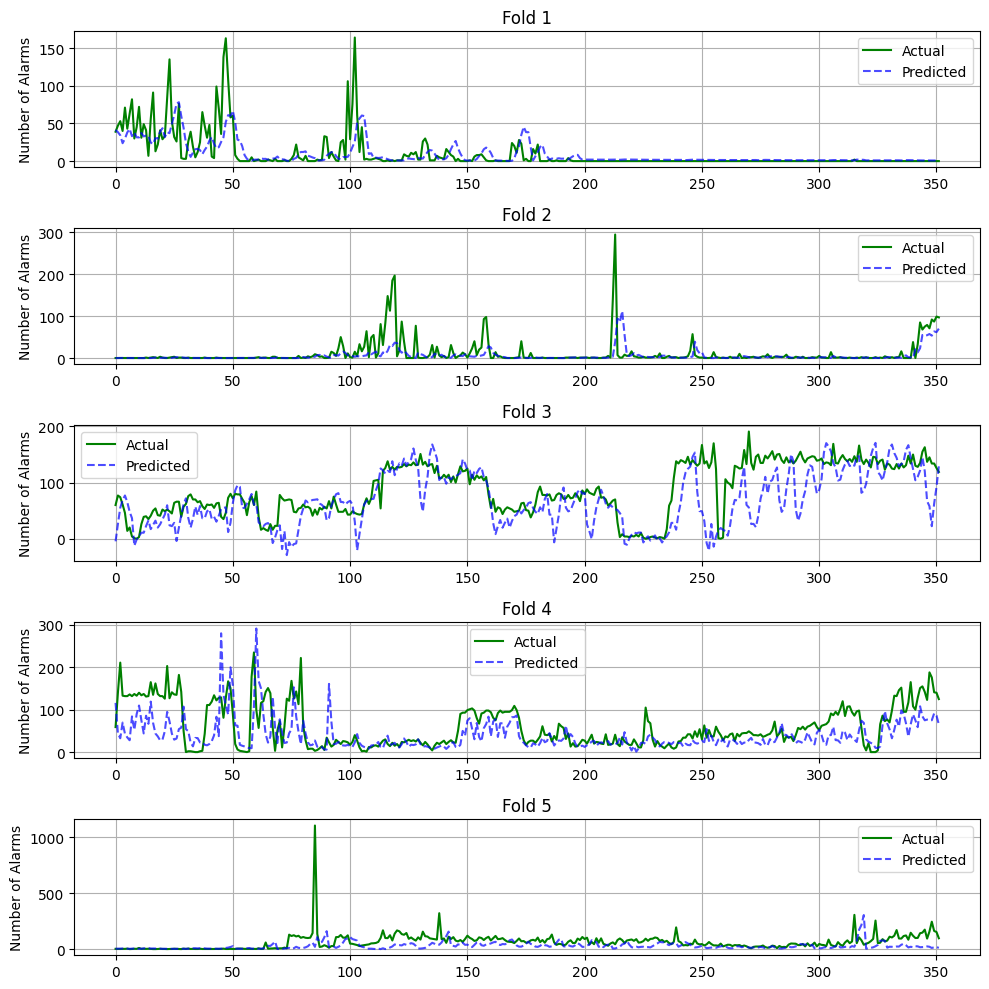

In [ ]:
#| fig-cap: RNN Actual vs Predicted for All Folds with Exogenous Variables
#| label: fig-rnn-actual-vs-predicted

def plot_rnn_tscv(rnn_models, rnn_model, val_loader_list):
    daily_alarms_index_list = []
    for _, test_idx in tscv.split(daily_alarms):
        daily_alarms_index_list.append(daily_alarms.index[test_idx])  

    fig, axes = plt.subplots(
        nrows=tscv.get_n_splits(),
        ncols=1,
        figsize=(10, 2 * tscv.get_n_splits())
    )

    for fold, (val_loader, ax, rnn_state, daily_alarm_index) in enumerate(
        zip(val_loader_list, axes, rnn_models, daily_alarms_index_list),
        start=1
    ):
        all_preds = []
        all_true = []

        rnn_model.load_state_dict(rnn_state)
        rnn_model.eval()

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = rnn_model(xb)
                all_preds.append(preds.detach().cpu().numpy())
                all_true.append(yb.detach().cpu().numpy())

        preds = np.vstack(all_preds)
        true = np.vstack(all_true)

        ax.plot( true, label='Actual', color='green')
        ax.plot( preds, label='Predicted', color='blue', alpha=0.7, linestyle='--')
        ax.set_title(f'Fold {fold}')
        ax.set_ylabel('Number of Alarms')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
rnn_params = best_model_params['rnn']
rnn_model = rnn_params['model']
rnn_models = rnn_params['model_states']
val_loader_list = rnn_params['val_loader_list']
plot_rnn_tscv(rnn_models, rnn_model, val_loader_list)


The optimized hyperparameters for the RNN model are:

- Lookback window: 4
- Batch size: 16
- Hidden size: 5
- Number of layers: 1
- Learning rate: $6.7 \times 10^{-4}$

\subsection*{Conclusion}
As observed for the SARIMAX models, including too many exogenous variables worsen performance by introducing additional noise. The RNN model without exogenous variables performs better than the variants that includes them. The lookback window of this model is 3 days, which means recent observations contain most of the relevant information for predicting the next day’s alarm count.

Both RNN-based models are optimized using Optuna with 50 trials and trained on an NVIDIA A100 GPU. The total optimization runtime is approximately 33 minutes and 42 minutes, respectively.



## LSTM
For the LSTM model, we use the same data preprocessing, training, hyperparameter optimization, and evaluation setup as for the RNN, replacing the recurrent with an LSTM layer. Another change is that the lookback window is increased to 128 days in order to explore potential long-term dependencies. 

### Alarms
@fig-lstm-actual-vs-predicted_lockback_long presents the time series cross-validation results for this model.

In [69]:
import pickle

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(partial(objective, model_type="lstm",verbose=True), n_trials=30)


[I 2026-01-30 01:48:38,417] A new study created in memory with name: no-name-d2209180-fc94-490a-ac9b-a52880eef9ef


Fold 1 - Epoch 5/50 - train: 733.1128 - val: 662.2650
Fold 1 - Epoch 10/50 - train: 697.5711 - val: 634.0084
Fold 1 - Epoch 15/50 - train: 678.6643 - val: 616.6626
Fold 1 - Epoch 20/50 - train: 659.6474 - val: 601.5442
Fold 1 - Epoch 25/50 - train: 640.1380 - val: 587.2149
Fold 1 - Epoch 30/50 - train: 622.7056 - val: 575.6293
Fold 1 - Epoch 35/50 - train: 610.5219 - val: 562.3971
Fold 1 - Epoch 40/50 - train: 592.3422 - val: 551.4889
Fold 1 - Epoch 45/50 - train: 585.9419 - val: 540.2141
Fold 1 - Epoch 50/50 - train: 565.4670 - val: 530.4603
Fold 2 - Epoch 5/50 - train: 728.8790 - val: 1000.8933
Fold 2 - Epoch 10/50 - train: 689.1358 - val: 968.6233
Fold 2 - Epoch 15/50 - train: 663.2011 - val: 950.2434
Fold 2 - Epoch 20/50 - train: 644.7142 - val: 933.0896
Fold 2 - Epoch 25/50 - train: 620.2155 - val: 917.4303
Fold 2 - Epoch 30/50 - train: 598.5324 - val: 902.9435
Fold 2 - Epoch 35/50 - train: 584.3606 - val: 889.5568
Fold 2 - Epoch 40/50 - train: 564.6254 - val: 877.2551
Fold 2 - Ep

[I 2026-01-30 01:49:57,344] Trial 0 finished with value: 51.93999481201172 and parameters: {'lookback': 5, 'batch_size': 16, 'hidden_size': 2, 'num_layers': 1, 'learning_rate': 0.0014078451062457585}. Best is trial 0 with value: 51.93999481201172.


Fold 5 - Epoch 50/50 - train: 1839.3731 - val: 7234.9466
Fold 1 - Epoch 5/50 - train: 625.3900 - val: 589.9916
Fold 1 - Epoch 10/50 - train: 529.4204 - val: 511.9023
Fold 1 - Epoch 15/50 - train: 466.7455 - val: 467.8729
Fold 1 - Epoch 20/50 - train: 425.0490 - val: 430.6040
Fold 1 - Epoch 25/50 - train: 389.2266 - val: 403.6278
Fold 1 - Epoch 30/50 - train: 370.3439 - val: 381.2483
Fold 1 - Epoch 35/50 - train: 352.2694 - val: 365.6304
Fold 1 - Epoch 40/50 - train: 340.2998 - val: 351.9530
Fold 1 - Epoch 45/50 - train: 327.6128 - val: 339.1432
Fold 1 - Epoch 50/50 - train: 317.8823 - val: 328.2313
Fold 2 - Epoch 5/50 - train: 636.6444 - val: 742.1798
Fold 2 - Epoch 10/50 - train: 516.1917 - val: 691.0777
Fold 2 - Epoch 15/50 - train: 453.7537 - val: 663.3923
Fold 2 - Epoch 20/50 - train: 407.2310 - val: 640.9433
Fold 2 - Epoch 25/50 - train: 381.6992 - val: 623.5564
Fold 2 - Epoch 30/50 - train: 360.0747 - val: 605.3068
Fold 2 - Epoch 35/50 - train: 341.5304 - val: 589.6033
Fold 2 - E

[I 2026-01-30 01:50:23,669] Trial 1 finished with value: 36.076866149902344 and parameters: {'lookback': 5, 'batch_size': 64, 'hidden_size': 22, 'num_layers': 1, 'learning_rate': 0.00372621874449789}. Best is trial 1 with value: 36.076866149902344.


Fold 5 - Epoch 50/50 - train: 703.6543 - val: 3963.9262
Fold 1 - Epoch 5/50 - train: 641.0066 - val: 601.5697
Fold 1 - Epoch 10/50 - train: 571.2470 - val: 545.6161
Fold 1 - Epoch 15/50 - train: 505.1959 - val: 498.6696
Fold 1 - Epoch 20/50 - train: 462.0510 - val: 466.6966
Fold 1 - Epoch 25/50 - train: 433.5243 - val: 445.9871
Fold 1 - Epoch 30/50 - train: 411.7158 - val: 425.8387
Fold 1 - Epoch 35/50 - train: 389.0480 - val: 401.0456
Fold 1 - Epoch 40/50 - train: 375.1473 - val: 385.1575
Fold 1 - Epoch 45/50 - train: 359.1929 - val: 372.4029
Fold 1 - Epoch 50/50 - train: 345.5724 - val: 364.2165
Fold 2 - Epoch 5/50 - train: 646.6536 - val: 744.4688
Fold 2 - Epoch 10/50 - train: 558.6993 - val: 708.7317
Fold 2 - Epoch 15/50 - train: 492.3523 - val: 678.2023
Fold 2 - Epoch 20/50 - train: 450.5879 - val: 658.5140
Fold 2 - Epoch 25/50 - train: 416.2702 - val: 643.0369
Fold 2 - Epoch 30/50 - train: 388.2457 - val: 630.6964
Fold 2 - Epoch 35/50 - train: 371.3659 - val: 619.7605
Fold 2 - Ep

[I 2026-01-30 01:50:40,793] Trial 2 finished with value: 37.84204864501953 and parameters: {'lookback': 5, 'batch_size': 128, 'hidden_size': 29, 'num_layers': 1, 'learning_rate': 0.003978345474386764}. Best is trial 1 with value: 36.076866149902344.


Fold 5 - Epoch 50/50 - train: 876.9647 - val: 4155.5480
Fold 1 - Epoch 5/50 - train: 654.5130 - val: 213.5481
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 642.1248 - val: 976.9378
Fold 2 - Epoch 10/50 - train: 623.9846 - val: 961.1183
Fold 2 - Epoch 15/50 - train: 503.2850 - val: 883.9902
Fold 2 - Epoch 20/50 - train: 415.9007 - val: 828.1637
Fold 2 - Epoch 25/50 - train: 370.1650 - val: 789.1314
Fold 2 - Epoch 30/50 - train: 350.5541 - val: 761.6152
Fold 2 - Epoch 35/50 - train: 326.1309 - val: 741.8880
Fold 2 - Epoch 40/50 - train: 322.9529 - val: 729.0383
Fold 2 - Epoch 45/50 - train: 313.5928 - val: 718.9366
Fold 2 - Epoch 50/50 - train: 307.0250 - val: 714.7483
Fold 3 - Epoch 5/50 - train: 676.2005 - val: 8928.7467
Fold 3 - Epoch 10/50 - train: 630.6031 - val: 8372.5491
Fold 3 - Epoch 15/50 - train: 487.0992 - val: 7147.8484
Fold 3 - Epoch 20/50 - train: 428.4634 - val: 6202.8898
Fold 3 - Epoch 25/50 - train: 397.4394 - val: 5500.5598
Fold 3 - Epoch 30/50 - train: 379.775

[I 2026-01-30 01:51:51,715] Trial 3 finished with value: 32.28530502319336 and parameters: {'lookback': 65, 'batch_size': 16, 'hidden_size': 22, 'num_layers': 1, 'learning_rate': 0.0017654021691542545}. Best is trial 3 with value: 32.28530502319336.


Fold 5 - Epoch 50/50 - train: 487.3016 - val: 4502.6324
Fold 1 - Epoch 5/50 - train: 661.1395 - val: 232.8885
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 653.5992 - val: 1214.0491
Fold 2 - Epoch 10/50 - train: 616.4635 - val: 1154.8658
Fold 2 - Epoch 15/50 - train: 447.8756 - val: 1046.3780
Fold 2 - Epoch 20/50 - train: 386.6102 - val: 974.6397
Fold 2 - Epoch 25/50 - train: 354.5881 - val: 916.8243
Fold 2 - Epoch 30/50 - train: 331.3261 - val: 888.2419
Fold 2 - Epoch 35/50 - train: 326.0112 - val: 863.4483
Fold 2 - Epoch 40/50 - train: 314.5092 - val: 836.6078
Fold 2 - Epoch 45/50 - train: 314.9549 - val: 828.3138
Fold 2 - Epoch 50/50 - train: 317.2307 - val: 817.3094
Fold 3 - Epoch 5/50 - train: 667.6360 - val: 9934.3512
Fold 3 - Epoch 10/50 - train: 544.5730 - val: 8682.1792
Fold 3 - Epoch 15/50 - train: 431.7253 - val: 7127.8469
Fold 3 - Epoch 20/50 - train: 392.3323 - val: 6150.4442
Fold 3 - Epoch 25/50 - train: 379.9970 - val: 5495.7620
Fold 3 - Epoch 30/50 - train: 364.

[I 2026-01-30 01:52:30,671] Trial 4 finished with value: 32.070472717285156 and parameters: {'lookback': 102, 'batch_size': 32, 'hidden_size': 20, 'num_layers': 1, 'learning_rate': 0.004730752844325125}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 452.8101 - val: 1169.2024
Fold 1 - Epoch 5/50 - train: 805.0483 - val: 25.5920
Fold 1 - Epoch 10/50 - train: 768.7573 - val: 23.9851
Fold 1 - Epoch 15/50 - train: 750.5826 - val: 21.1037
Fold 1 - Epoch 20/50 - train: 733.9024 - val: 25.7737
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 780.5643 - val: 967.4276
Fold 2 - Epoch 10/50 - train: 743.6756 - val: 945.2026
Fold 2 - Epoch 15/50 - train: 724.1679 - val: 935.4903
Fold 2 - Epoch 20/50 - train: 704.8913 - val: 934.6535
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 773.3377 - val: 8786.7848
Fold 3 - Epoch 10/50 - train: 742.5163 - val: 8574.4055
Fold 3 - Epoch 15/50 - train: 728.2360 - val: 8455.8608
Fold 3 - Epoch 20/50 - train: 717.8487 - val: 8359.1921
Fold 3 - Epoch 25/50 - train: 696.1775 - val: 8250.6935
Fold 3 - Epoch 30/50 - train: 686.0750 - val: 8148.8608
Fold 3 - Epoch 35/50 - train: 673.1733 - val: 8051.9429
Fold 3 - Epoch 40/50 - train: 663.6090 - val: 7960.5051
Fold 3 - Epoc

[I 2026-01-30 01:52:57,508] Trial 5 finished with value: 45.50015640258789 and parameters: {'lookback': 121, 'batch_size': 64, 'hidden_size': 6, 'num_layers': 3, 'learning_rate': 0.0012049549733080752}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 2108.7200 - val: 3647.1829
Fold 1 - Epoch 5/50 - train: 753.4070 - val: 701.6298
Fold 1 - Epoch 10/50 - train: 749.8520 - val: 698.5937
Fold 1 - Epoch 15/50 - train: 746.3781 - val: 695.5643
Fold 1 - Epoch 20/50 - train: 742.1057 - val: 691.8456
Fold 1 - Epoch 25/50 - train: 736.5911 - val: 686.9815
Fold 1 - Epoch 30/50 - train: 729.5431 - val: 680.9012
Fold 1 - Epoch 35/50 - train: 723.1230 - val: 674.5710
Fold 1 - Epoch 40/50 - train: 715.6597 - val: 668.6625
Fold 1 - Epoch 45/50 - train: 708.5838 - val: 663.4503
Fold 1 - Epoch 50/50 - train: 703.5880 - val: 658.7236
Fold 2 - Epoch 5/50 - train: 744.7604 - val: 806.0958
Fold 2 - Epoch 10/50 - train: 740.7328 - val: 803.3929
Fold 2 - Epoch 15/50 - train: 736.1797 - val: 800.3678
Fold 2 - Epoch 20/50 - train: 730.1417 - val: 796.3019
Fold 2 - Epoch 25/50 - train: 721.8849 - val: 790.8694
Fold 2 - Epoch 30/50 - train: 712.9244 - val: 785.1622
Fold 2 - Epoch 35/50 - train: 705.2035 - val: 780.1648
Fold 2 - E

[I 2026-01-30 01:53:27,255] Trial 6 finished with value: 54.80247497558594 and parameters: {'lookback': 2, 'batch_size': 64, 'hidden_size': 3, 'num_layers': 2, 'learning_rate': 0.0005866732359998499}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 2279.8853 - val: 7361.8493
Fold 1 - Epoch 5/50 - train: 728.3961 - val: 618.0712
Fold 1 - Epoch 10/50 - train: 709.1013 - val: 602.9234
Fold 1 - Epoch 15/50 - train: 693.4991 - val: 590.9861
Fold 1 - Epoch 20/50 - train: 675.2554 - val: 578.3566
Fold 1 - Epoch 25/50 - train: 666.6221 - val: 570.4150
Fold 1 - Epoch 30/50 - train: 659.4403 - val: 564.4052
Fold 1 - Epoch 35/50 - train: 649.4608 - val: 559.4514
Fold 1 - Epoch 40/50 - train: 646.8288 - val: 555.3069
Fold 1 - Epoch 45/50 - train: 641.2961 - val: 551.7738
Fold 1 - Epoch 50/50 - train: 633.6498 - val: 548.7656
Fold 2 - Epoch 5/50 - train: 741.7505 - val: 822.3366
Fold 2 - Epoch 10/50 - train: 718.2269 - val: 806.7990
Fold 2 - Epoch 15/50 - train: 695.1323 - val: 791.5151
Fold 2 - Epoch 20/50 - train: 678.4538 - val: 782.3762
Fold 2 - Epoch 25/50 - train: 667.3516 - val: 776.0389
Fold 2 - Epoch 30/50 - train: 659.4745 - val: 771.1796
Fold 2 - Epoch 35/50 - train: 655.6696 - val: 767.4073
Fold 2 - E

[I 2026-01-30 01:54:00,250] Trial 7 finished with value: 51.8443489074707 and parameters: {'lookback': 12, 'batch_size': 64, 'hidden_size': 5, 'num_layers': 3, 'learning_rate': 0.0017291380099611875}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 2048.7698 - val: 7145.8789
Fold 1 - Epoch 5/50 - train: 715.8794 - val: 700.6775
Fold 1 - Epoch 10/50 - train: 714.2119 - val: 699.0240
Fold 1 - Epoch 15/50 - train: 711.2793 - val: 696.2819
Fold 1 - Epoch 20/50 - train: 706.0542 - val: 691.1747
Fold 1 - Epoch 25/50 - train: 697.2461 - val: 682.5806
Fold 1 - Epoch 30/50 - train: 685.8491 - val: 671.9615
Fold 1 - Epoch 35/50 - train: 675.4658 - val: 662.0140
Fold 1 - Epoch 40/50 - train: 667.1823 - val: 653.8368
Fold 1 - Epoch 45/50 - train: 660.5581 - val: 647.2492
Fold 1 - Epoch 50/50 - train: 655.2963 - val: 641.7748
Fold 2 - Epoch 5/50 - train: 743.9664 - val: 801.7509
Fold 2 - Epoch 10/50 - train: 741.0224 - val: 799.6776
Fold 2 - Epoch 15/50 - train: 734.5096 - val: 795.0868
Fold 2 - Epoch 20/50 - train: 721.6589 - val: 786.3752
Fold 2 - Epoch 25/50 - train: 705.5511 - val: 776.4595
Fold 2 - Epoch 30/50 - train: 692.9088 - val: 768.5852
Fold 2 - Epoch 35/50 - train: 683.2621 - val: 762.7545
Fold 2 - E

[I 2026-01-30 01:54:20,315] Trial 8 finished with value: 53.0349006652832 and parameters: {'lookback': 1, 'batch_size': 128, 'hidden_size': 9, 'num_layers': 3, 'learning_rate': 0.0007547944846482187}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 2172.2090 - val: 6741.4303
Fold 1 - Epoch 5/50 - train: 710.1783 - val: 695.0671
Fold 1 - Epoch 10/50 - train: 704.0600 - val: 688.8663
Fold 1 - Epoch 15/50 - train: 692.4553 - val: 677.8559
Fold 1 - Epoch 20/50 - train: 672.5711 - val: 659.0353
Fold 1 - Epoch 25/50 - train: 659.4526 - val: 645.0716
Fold 1 - Epoch 30/50 - train: 644.1856 - val: 634.8912
Fold 1 - Epoch 35/50 - train: 628.0857 - val: 621.9341
Fold 1 - Epoch 40/50 - train: 615.7982 - val: 610.1734
Fold 1 - Epoch 45/50 - train: 602.6819 - val: 599.8722
Fold 1 - Epoch 50/50 - train: 594.1879 - val: 590.4380
Fold 2 - Epoch 5/50 - train: 736.6602 - val: 796.6247
Fold 2 - Epoch 10/50 - train: 725.5750 - val: 788.9918
Fold 2 - Epoch 15/50 - train: 700.1144 - val: 772.2836
Fold 2 - Epoch 20/50 - train: 680.6526 - val: 760.0867
Fold 2 - Epoch 25/50 - train: 662.9804 - val: 753.0069
Fold 2 - Epoch 30/50 - train: 644.3675 - val: 742.8025
Fold 2 - Epoch 35/50 - train: 626.8365 - val: 733.9433
Fold 2 - E

[I 2026-01-30 01:54:40,372] Trial 9 finished with value: 50.683319091796875 and parameters: {'lookback': 1, 'batch_size': 128, 'hidden_size': 4, 'num_layers': 3, 'learning_rate': 0.004400633090109042}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 1928.4789 - val: 6304.6144
Fold 1 - Epoch 5/50 - train: 631.6483 - val: 441.5934
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 632.3824 - val: 840.7554
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 651.6208 - val: 7974.1152
Fold 3 - Epoch 10/50 - train: 653.4306 - val: 7885.8508
Fold 3 - Epoch 15/50 - train: 653.9749 - val: 7869.2542
Fold 3 - Epoch 20/50 - train: 658.2823 - val: 8117.4970
Early stopping triggered
Fold 4 - Epoch 5/50 - train: 1618.3167 - val: 2977.4285
Fold 4 - Epoch 10/50 - train: 1611.7007 - val: 2773.5792
Fold 4 - Epoch 15/50 - train: 1755.8404 - val: 4214.5472
Early stopping triggered
Fold 5 - Epoch 5/50 - train: 1903.7747 - val: 7120.7913
Fold 5 - Epoch 10/50 - train: 1873.5057 - val: 6798.5118
Fold 5 - Epoch 15/50 - train: 1621.4679 - val: 6040.9270
Fold 5 - Epoch 20/50 - train: 947.3432 - val: 5116.3544
Fold 5 - Epoch 25/50 - train: 770.0966 - val: 4597.6128
Fold 5 - Epoch 30/50 - train: 637.0709 - val: 4271.4337
Fold

[I 2026-01-30 01:55:04,757] Trial 10 finished with value: 48.84874725341797 and parameters: {'lookback': 30, 'batch_size': 32, 'hidden_size': 15, 'num_layers': 2, 'learning_rate': 0.008459781981158257}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 447.8765 - val: 3951.0010
Fold 1 - Epoch 5/50 - train: 718.6339 - val: 33.5814
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 695.2981 - val: 1013.0841
Fold 2 - Epoch 10/50 - train: 666.2057 - val: 997.6591
Fold 2 - Epoch 15/50 - train: 649.6369 - val: 980.1352
Fold 2 - Epoch 20/50 - train: 571.1617 - val: 999.3708
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 732.2223 - val: 10144.7395
Fold 3 - Epoch 10/50 - train: 713.3346 - val: 9712.8962
Fold 3 - Epoch 15/50 - train: 626.2359 - val: 9129.9599
Fold 3 - Epoch 20/50 - train: 570.9394 - val: 8518.6144
Fold 3 - Epoch 25/50 - train: 523.5390 - val: 7961.4805
Fold 3 - Epoch 30/50 - train: 486.4939 - val: 7464.3925
Fold 3 - Epoch 35/50 - train: 461.6121 - val: 7013.5732
Fold 3 - Epoch 40/50 - train: 438.6456 - val: 6623.2832
Fold 3 - Epoch 45/50 - train: 426.8229 - val: 6281.6714
Fold 3 - Epoch 50/50 - train: 405.4795 - val: 5975.9738
Fold 4 - Epoch 5/50 - train: 1822.7526 - val: 2298.6009
Fold 

[I 2026-01-30 01:55:44,723] Trial 11 finished with value: 37.469215393066406 and parameters: {'lookback': 118, 'batch_size': 32, 'hidden_size': 12, 'num_layers': 2, 'learning_rate': 0.0024633062897939095}. Best is trial 4 with value: 32.070472717285156.


Fold 5 - Epoch 50/50 - train: 1286.2359 - val: 2525.1165
Fold 1 - Epoch 5/50 - train: 640.6986 - val: 454.2803
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 639.7832 - val: 1041.7565
Fold 2 - Epoch 10/50 - train: 439.0489 - val: 847.7388
Fold 2 - Epoch 15/50 - train: 335.4644 - val: 755.3939
Fold 2 - Epoch 20/50 - train: 317.3846 - val: 727.1128
Fold 2 - Epoch 25/50 - train: 314.5416 - val: 703.8736
Fold 2 - Epoch 30/50 - train: 297.7302 - val: 697.7533
Fold 2 - Epoch 35/50 - train: 294.1437 - val: 678.5690
Fold 2 - Epoch 40/50 - train: 290.6994 - val: 664.1044
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 682.5257 - val: 8472.0974
Fold 3 - Epoch 10/50 - train: 434.5292 - val: 6125.5863
Fold 3 - Epoch 15/50 - train: 381.1563 - val: 4756.2531
Fold 3 - Epoch 20/50 - train: 355.6261 - val: 3977.5365
Fold 3 - Epoch 25/50 - train: 349.0871 - val: 3457.5927
Fold 3 - Epoch 30/50 - train: 336.1679 - val: 3107.9658
Fold 3 - Epoch 35/50 - train: 329.0119 - val: 2825.2593
Fold 3 -

[I 2026-01-30 01:56:47,564] Trial 12 finished with value: 29.65355682373047 and parameters: {'lookback': 45, 'batch_size': 16, 'hidden_size': 18, 'num_layers': 1, 'learning_rate': 0.00690440016441362}. Best is trial 12 with value: 29.65355682373047.


Fold 5 - Epoch 40/50 - train: 379.5723 - val: 4194.0339
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 632.6464 - val: 496.2614
Fold 1 - Epoch 10/50 - train: 542.0048 - val: 417.4691
Fold 1 - Epoch 15/50 - train: 402.0556 - val: 359.6873
Fold 1 - Epoch 20/50 - train: 356.6537 - val: 331.4707
Fold 1 - Epoch 25/50 - train: 334.6312 - val: 311.5255
Fold 1 - Epoch 30/50 - train: 314.1696 - val: 302.8885
Fold 1 - Epoch 35/50 - train: 321.6981 - val: 295.0093
Fold 1 - Epoch 40/50 - train: 310.1489 - val: 291.6894
Fold 1 - Epoch 45/50 - train: 314.4422 - val: 286.6636
Fold 1 - Epoch 50/50 - train: 305.9409 - val: 284.0310
Fold 2 - Epoch 5/50 - train: 626.9565 - val: 783.1700
Fold 2 - Epoch 10/50 - train: 464.1533 - val: 689.3467
Fold 2 - Epoch 15/50 - train: 372.4368 - val: 657.2504
Fold 2 - Epoch 20/50 - train: 341.6191 - val: 627.2363
Fold 2 - Epoch 25/50 - train: 323.0699 - val: 624.9539
Fold 2 - Epoch 30/50 - train: 314.2039 - val: 619.3834
Fold 2 - Epoch 35/50 - train: 301.5823 - 

[I 2026-01-30 01:57:30,372] Trial 13 finished with value: 30.865550994873047 and parameters: {'lookback': 25, 'batch_size': 32, 'hidden_size': 14, 'num_layers': 1, 'learning_rate': 0.007580006826498634}. Best is trial 12 with value: 29.65355682373047.


Fold 5 - Epoch 50/50 - train: 426.4198 - val: 3822.4617
Fold 1 - Epoch 5/50 - train: 627.1770 - val: 510.1261
Fold 1 - Epoch 10/50 - train: 418.0420 - val: 363.7528
Fold 1 - Epoch 15/50 - train: 356.4616 - val: 319.9723
Fold 1 - Epoch 20/50 - train: 328.0112 - val: 303.2026
Fold 1 - Epoch 25/50 - train: 313.9344 - val: 295.1759
Fold 1 - Epoch 30/50 - train: 319.7251 - val: 291.6758
Fold 1 - Epoch 35/50 - train: 318.5671 - val: 288.3228
Fold 1 - Epoch 40/50 - train: 305.4563 - val: 285.2114
Fold 1 - Epoch 45/50 - train: 289.3603 - val: 280.2544
Fold 1 - Epoch 50/50 - train: 302.8117 - val: 276.6838
Fold 2 - Epoch 5/50 - train: 596.5440 - val: 915.8012
Fold 2 - Epoch 10/50 - train: 384.7443 - val: 779.9094
Fold 2 - Epoch 15/50 - train: 333.5306 - val: 712.3910
Fold 2 - Epoch 20/50 - train: 321.7338 - val: 678.2795
Fold 2 - Epoch 25/50 - train: 312.8119 - val: 664.9208
Fold 2 - Epoch 30/50 - train: 307.4668 - val: 637.1795
Fold 2 - Epoch 35/50 - train: 292.4290 - val: 629.5795
Fold 2 - Ep

[I 2026-01-30 01:58:49,206] Trial 14 finished with value: 29.748899459838867 and parameters: {'lookback': 24, 'batch_size': 16, 'hidden_size': 10, 'num_layers': 1, 'learning_rate': 0.008911040902664391}. Best is trial 12 with value: 29.65355682373047.


Fold 5 - Epoch 50/50 - train: 400.1833 - val: 3896.0969
Fold 1 - Epoch 5/50 - train: 635.4724 - val: 440.4101
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 638.4057 - val: 982.7654
Fold 2 - Epoch 10/50 - train: 532.0290 - val: 938.3212
Fold 2 - Epoch 15/50 - train: 389.8468 - val: 777.7932
Fold 2 - Epoch 20/50 - train: 334.8248 - val: 737.9408
Fold 2 - Epoch 25/50 - train: 333.8482 - val: 716.4034
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 679.2442 - val: 8316.2014
Fold 3 - Epoch 10/50 - train: 680.3588 - val: 8252.2473
Fold 3 - Epoch 15/50 - train: 550.9509 - val: 7402.0820
Fold 3 - Epoch 20/50 - train: 426.5836 - val: 5728.5519
Fold 3 - Epoch 25/50 - train: 389.3622 - val: 4839.9553
Fold 3 - Epoch 30/50 - train: 382.9772 - val: 4504.6695
Fold 3 - Epoch 35/50 - train: 368.4054 - val: 3942.9946
Fold 3 - Epoch 40/50 - train: 358.5121 - val: 3637.2583
Fold 3 - Epoch 45/50 - train: 340.1357 - val: 3333.6315
Fold 3 - Epoch 50/50 - train: 323.6292 - val: 3140.6181
Fold 4 

[I 2026-01-30 01:59:41,939] Trial 15 finished with value: 36.28853225708008 and parameters: {'lookback': 37, 'batch_size': 16, 'hidden_size': 8, 'num_layers': 2, 'learning_rate': 0.009520255012409449}. Best is trial 12 with value: 29.65355682373047.


Fold 5 - Epoch 15/50 - train: 1813.1763 - val: 7945.8108
Early stopping triggered
Fold 1 - Epoch 5/50 - train: 631.9332 - val: 535.7206
Fold 1 - Epoch 10/50 - train: 626.2418 - val: 541.7128
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 628.7930 - val: 806.0134
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 655.1194 - val: 7731.5787
Fold 3 - Epoch 10/50 - train: 537.0652 - val: 6950.5564
Fold 3 - Epoch 15/50 - train: 424.9825 - val: 5489.2152
Fold 3 - Epoch 20/50 - train: 378.6105 - val: 4641.0378
Fold 3 - Epoch 25/50 - train: 359.6841 - val: 4078.8158
Fold 3 - Epoch 30/50 - train: 341.7954 - val: 3649.2866
Fold 3 - Epoch 35/50 - train: 330.1891 - val: 3317.3374
Fold 3 - Epoch 40/50 - train: 316.8604 - val: 3046.8364
Fold 3 - Epoch 45/50 - train: 302.2720 - val: 2796.0033
Fold 3 - Epoch 50/50 - train: 296.8804 - val: 2573.7023
Fold 4 - Epoch 5/50 - train: 1618.0724 - val: 3582.4188
Fold 4 - Epoch 10/50 - train: 1590.1206 - val: 3805.0091
Fold 4 - Epoch 15/50 - train: 129

[I 2026-01-30 02:00:46,791] Trial 16 finished with value: 38.767459869384766 and parameters: {'lookback': 14, 'batch_size': 16, 'hidden_size': 10, 'num_layers': 2, 'learning_rate': 0.006021925812563211}. Best is trial 12 with value: 29.65355682373047.


Fold 5 - Epoch 50/50 - train: 387.1768 - val: 3804.1586
Fold 1 - Epoch 5/50 - train: 639.4580 - val: 243.0316
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 635.2364 - val: 1055.3245
Fold 2 - Epoch 10/50 - train: 617.1071 - val: 1029.5691
Fold 2 - Epoch 15/50 - train: 433.7203 - val: 881.3907
Fold 2 - Epoch 20/50 - train: 360.6022 - val: 813.6818
Fold 2 - Epoch 25/50 - train: 323.3362 - val: 769.9853
Fold 2 - Epoch 30/50 - train: 310.6809 - val: 733.6713
Fold 2 - Epoch 35/50 - train: 307.7844 - val: 734.5114
Fold 2 - Epoch 40/50 - train: 300.2210 - val: 711.8142
Fold 2 - Epoch 45/50 - train: 299.6252 - val: 738.4547
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 687.1197 - val: 8779.6252
Fold 3 - Epoch 10/50 - train: 641.4151 - val: 8248.3700
Fold 3 - Epoch 15/50 - train: 455.6054 - val: 6422.5557
Fold 3 - Epoch 20/50 - train: 396.8149 - val: 5254.2602
Fold 3 - Epoch 25/50 - train: 366.5189 - val: 4513.5695
Fold 3 - Epoch 30/50 - train: 358.7950 - val: 4020.5310
Fold 3 - 

[I 2026-01-30 02:01:54,679] Trial 17 finished with value: 30.09339141845703 and parameters: {'lookback': 56, 'batch_size': 16, 'hidden_size': 29, 'num_layers': 1, 'learning_rate': 0.0026472718753075527}. Best is trial 12 with value: 29.65355682373047.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 628.6671 - val: 531.2823
Fold 1 - Epoch 10/50 - train: 428.6255 - val: 379.2794
Fold 1 - Epoch 15/50 - train: 351.8495 - val: 333.7781
Fold 1 - Epoch 20/50 - train: 318.8816 - val: 316.4597
Fold 1 - Epoch 25/50 - train: 316.9561 - val: 305.2045
Fold 1 - Epoch 30/50 - train: 304.7018 - val: 297.1888
Fold 1 - Epoch 35/50 - train: 304.0451 - val: 294.2150
Fold 1 - Epoch 40/50 - train: 303.1079 - val: 291.9636
Fold 1 - Epoch 45/50 - train: 292.9370 - val: 290.0139
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 627.4812 - val: 866.4754
Fold 2 - Epoch 10/50 - train: 392.8196 - val: 712.3784
Fold 2 - Epoch 15/50 - train: 332.0494 - val: 658.2767
Fold 2 - Epoch 20/50 - train: 317.3497 - val: 633.4082
Fold 2 - Epoch 25/50 - train: 299.4671 - val: 626.2157
Fold 2 - Epoch 30/50 - train: 300.4747 - val: 610.1610
Fold 2 - Epoch 35/50 - train: 288.0946 - val: 612.8072
Fold 2 - Epoch 40/50 - train: 305.9160 - val: 614.4330
Early stopping tr

[I 2026-01-30 02:03:10,632] Trial 18 finished with value: 29.065753936767578 and parameters: {'lookback': 18, 'batch_size': 16, 'hidden_size': 15, 'num_layers': 1, 'learning_rate': 0.006368410864339237}. Best is trial 18 with value: 29.065753936767578.


Fold 5 - Epoch 50/50 - train: 388.8024 - val: 3754.5846
Fold 1 - Epoch 5/50 - train: 626.8050 - val: 550.8405
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 631.9913 - val: 962.3110
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 681.8129 - val: 8124.9352
Fold 3 - Epoch 10/50 - train: 684.0421 - val: 8102.7472
Fold 3 - Epoch 15/50 - train: 601.7737 - val: 8084.8039
Fold 3 - Epoch 20/50 - train: 413.5141 - val: 5392.3402
Fold 3 - Epoch 25/50 - train: 374.8229 - val: 4434.6182
Fold 3 - Epoch 30/50 - train: 351.8376 - val: 3861.7610
Fold 3 - Epoch 35/50 - train: 334.5892 - val: 3345.9412
Fold 3 - Epoch 40/50 - train: 306.9825 - val: 2952.0494
Fold 3 - Epoch 45/50 - train: 295.4529 - val: 2663.4101
Fold 3 - Epoch 50/50 - train: 288.2812 - val: 2405.2724
Fold 4 - Epoch 5/50 - train: 1600.7537 - val: 3752.6808
Fold 4 - Epoch 10/50 - train: 1601.0341 - val: 3621.0215
Fold 4 - Epoch 15/50 - train: 1385.9663 - val: 3757.4518
Fold 4 - Epoch 20/50 - train: 1612.5412 - val: 3542.1549


[I 2026-01-30 02:04:06,802] Trial 19 finished with value: 40.22464370727539 and parameters: {'lookback': 13, 'batch_size': 16, 'hidden_size': 18, 'num_layers': 2, 'learning_rate': 0.0059126672057718925}. Best is trial 18 with value: 29.065753936767578.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 642.9074 - val: 217.4534
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 638.7151 - val: 1061.5810
Fold 2 - Epoch 10/50 - train: 572.7795 - val: 987.6315
Fold 2 - Epoch 15/50 - train: 423.8993 - val: 890.4497
Fold 2 - Epoch 20/50 - train: 372.8779 - val: 833.3981
Fold 2 - Epoch 25/50 - train: 345.8785 - val: 796.1240
Fold 2 - Epoch 30/50 - train: 329.6719 - val: 765.4407
Fold 2 - Epoch 35/50 - train: 322.4588 - val: 749.2576
Fold 2 - Epoch 40/50 - train: 312.3856 - val: 739.8165
Fold 2 - Epoch 45/50 - train: 310.0115 - val: 724.8431
Fold 2 - Epoch 50/50 - train: 308.5295 - val: 724.7528
Early stopping triggered
Fold 3 - Epoch 5/50 - train: 688.2627 - val: 8954.0170
Fold 3 - Epoch 10/50 - train: 538.1892 - val: 7647.6272
Fold 3 - Epoch 15/50 - train: 442.5612 - val: 6370.8938
Fold 3 - Epoch 20/50 - train: 406.1866 - val: 5504.7573
Fold 3 - Epoch 25/50 - train: 379.4420 - val: 4888.0493
Fold 3 - Epoch 30/50 - train: 367.2014 - v

[I 2026-01-30 02:05:17,109] Trial 20 finished with value: 31.59517478942871 and parameters: {'lookback': 56, 'batch_size': 16, 'hidden_size': 15, 'num_layers': 1, 'learning_rate': 0.0031594023534110543}. Best is trial 18 with value: 29.065753936767578.


Fold 5 - Epoch 50/50 - train: 424.4033 - val: 4333.6823
Fold 1 - Epoch 5/50 - train: 626.4935 - val: 523.0534
Fold 1 - Epoch 10/50 - train: 485.1105 - val: 414.7712
Fold 1 - Epoch 15/50 - train: 380.7803 - val: 353.4151
Fold 1 - Epoch 20/50 - train: 340.7982 - val: 326.7870
Fold 1 - Epoch 25/50 - train: 325.2617 - val: 312.1363
Fold 1 - Epoch 30/50 - train: 308.4173 - val: 304.5935
Fold 1 - Epoch 35/50 - train: 299.6255 - val: 298.6716
Fold 1 - Epoch 40/50 - train: 305.0896 - val: 299.1649
Fold 1 - Epoch 45/50 - train: 289.8079 - val: 294.1954
Fold 1 - Epoch 50/50 - train: 284.8469 - val: 295.2518
Fold 2 - Epoch 5/50 - train: 625.8843 - val: 920.4153
Fold 2 - Epoch 10/50 - train: 434.0345 - val: 781.9914
Fold 2 - Epoch 15/50 - train: 351.3207 - val: 709.3059
Fold 2 - Epoch 20/50 - train: 325.2761 - val: 673.2106
Fold 2 - Epoch 25/50 - train: 309.6032 - val: 662.4282
Fold 2 - Epoch 30/50 - train: 307.9621 - val: 644.2068
Fold 2 - Epoch 35/50 - train: 295.1574 - val: 648.3833
Fold 2 - Ep

[I 2026-01-30 02:06:25,388] Trial 21 finished with value: 29.929262161254883 and parameters: {'lookback': 20, 'batch_size': 16, 'hidden_size': 11, 'num_layers': 1, 'learning_rate': 0.00652389317792031}. Best is trial 18 with value: 29.065753936767578.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 594.8656 - val: 503.6064
Fold 1 - Epoch 10/50 - train: 401.8835 - val: 389.4468
Fold 1 - Epoch 15/50 - train: 344.2434 - val: 349.5195
Fold 1 - Epoch 20/50 - train: 322.4788 - val: 327.3832
Fold 1 - Epoch 25/50 - train: 303.0365 - val: 314.6116
Fold 1 - Epoch 30/50 - train: 306.6927 - val: 308.4535
Fold 1 - Epoch 35/50 - train: 305.5067 - val: 305.2568
Fold 1 - Epoch 40/50 - train: 286.1718 - val: 305.7255
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 544.6735 - val: 845.7652
Fold 2 - Epoch 10/50 - train: 378.9873 - val: 715.2605
Fold 2 - Epoch 15/50 - train: 324.4258 - val: 662.2068
Fold 2 - Epoch 20/50 - train: 305.8230 - val: 633.0042
Fold 2 - Epoch 25/50 - train: 310.3424 - val: 617.1428
Fold 2 - Epoch 30/50 - train: 303.3728 - val: 602.2113
Fold 2 - Epoch 35/50 - train: 295.3361 - val: 598.0147
Fold 2 - Epoch 40/50 - train: 294.1557 - val: 588.7104
Fold 2 - Epoch 45/50 - train: 293.4786 - val: 580.1218
Fold 2 - Epoch 50

[I 2026-01-30 02:07:41,635] Trial 22 finished with value: 28.932235717773438 and parameters: {'lookback': 8, 'batch_size': 16, 'hidden_size': 8, 'num_layers': 1, 'learning_rate': 0.009865243917898881}. Best is trial 22 with value: 28.932235717773438.


Early stopping triggered
Fold 1 - Epoch 5/50 - train: 556.5798 - val: 503.9690
Fold 1 - Epoch 10/50 - train: 434.6272 - val: 420.5605
Fold 1 - Epoch 15/50 - train: 376.0866 - val: 376.3487
Fold 1 - Epoch 20/50 - train: 343.1919 - val: 347.0489
Fold 1 - Epoch 25/50 - train: 327.1330 - val: 330.1482
Fold 1 - Epoch 30/50 - train: 314.4813 - val: 317.0207
Fold 1 - Epoch 35/50 - train: 307.2400 - val: 312.2598
Fold 1 - Epoch 40/50 - train: 307.8023 - val: 307.6617
Fold 1 - Epoch 45/50 - train: 307.6525 - val: 301.4444
Fold 1 - Epoch 50/50 - train: 305.5835 - val: 299.1869
Fold 2 - Epoch 5/50 - train: 532.2177 - val: 857.0792
Fold 2 - Epoch 10/50 - train: 414.0599 - val: 753.6497
Fold 2 - Epoch 15/50 - train: 357.5630 - val: 695.6627
Fold 2 - Epoch 20/50 - train: 338.2193 - val: 663.4309
Fold 2 - Epoch 25/50 - train: 321.9678 - val: 644.4534
Fold 2 - Epoch 30/50 - train: 312.8517 - val: 629.6295
Fold 2 - Epoch 35/50 - train: 307.5871 - val: 616.0800
Fold 2 - Epoch 40/50 - train: 305.7997 - v

[I 2026-01-30 02:08:59,998] Trial 23 finished with value: 31.211029052734375 and parameters: {'lookback': 7, 'batch_size': 16, 'hidden_size': 8, 'num_layers': 1, 'learning_rate': 0.005947121972598885}. Best is trial 22 with value: 28.932235717773438.


Fold 5 - Epoch 50/50 - train: 442.9952 - val: 3739.8959
Fold 1 - Epoch 5/50 - train: 610.4465 - val: 534.7159
Fold 1 - Epoch 10/50 - train: 441.0610 - val: 406.5907
Fold 1 - Epoch 15/50 - train: 376.1075 - val: 360.3926
Fold 1 - Epoch 20/50 - train: 341.3502 - val: 338.8019
Fold 1 - Epoch 25/50 - train: 330.4367 - val: 324.5158
Fold 1 - Epoch 30/50 - train: 328.5381 - val: 316.6684
Fold 1 - Epoch 35/50 - train: 315.3963 - val: 311.9857
Fold 1 - Epoch 40/50 - train: 316.6144 - val: 305.1812
Fold 1 - Epoch 45/50 - train: 295.3521 - val: 302.9180
Fold 1 - Epoch 50/50 - train: 304.6876 - val: 302.2775
Fold 2 - Epoch 5/50 - train: 557.4966 - val: 867.0154
Fold 2 - Epoch 10/50 - train: 400.3387 - val: 745.9832
Fold 2 - Epoch 15/50 - train: 345.0152 - val: 690.0624
Fold 2 - Epoch 20/50 - train: 327.0959 - val: 660.5054
Fold 2 - Epoch 25/50 - train: 315.1029 - val: 638.3391
Fold 2 - Epoch 30/50 - train: 308.1573 - val: 626.3989
Fold 2 - Epoch 35/50 - train: 313.2903 - val: 612.4975
Fold 2 - Ep

[I 2026-01-30 02:10:18,803] Trial 24 finished with value: 30.368938446044922 and parameters: {'lookback': 9, 'batch_size': 16, 'hidden_size': 6, 'num_layers': 1, 'learning_rate': 0.00985737003493126}. Best is trial 22 with value: 28.932235717773438.


Fold 5 - Epoch 50/50 - train: 435.6917 - val: 3736.6006
Fold 1 - Epoch 5/50 - train: 463.9582 - val: 456.3026
Fold 1 - Epoch 10/50 - train: 366.9864 - val: 363.1727
Fold 1 - Epoch 15/50 - train: 321.7484 - val: 327.6441
Fold 1 - Epoch 20/50 - train: 320.4245 - val: 308.6087
Fold 1 - Epoch 25/50 - train: 298.8715 - val: 302.5515
Fold 1 - Epoch 30/50 - train: 303.3325 - val: 298.0429
Fold 1 - Epoch 35/50 - train: 293.5908 - val: 296.4845
Fold 1 - Epoch 40/50 - train: 299.5164 - val: 294.2800
Fold 1 - Epoch 45/50 - train: 294.3506 - val: 292.5522
Fold 1 - Epoch 50/50 - train: 293.8438 - val: 291.0621
Fold 2 - Epoch 5/50 - train: 445.8896 - val: 727.5031
Fold 2 - Epoch 10/50 - train: 344.5633 - val: 652.0738
Fold 2 - Epoch 15/50 - train: 317.3239 - val: 607.6645
Fold 2 - Epoch 20/50 - train: 308.7120 - val: 587.8316
Fold 2 - Epoch 25/50 - train: 304.7170 - val: 574.8720
Fold 2 - Epoch 30/50 - train: 293.1474 - val: 565.0761
Fold 2 - Epoch 35/50 - train: 290.2290 - val: 556.2596
Fold 2 - Ep

[I 2026-01-30 02:11:38,020] Trial 25 finished with value: 28.04222297668457 and parameters: {'lookback': 3, 'batch_size': 16, 'hidden_size': 17, 'num_layers': 1, 'learning_rate': 0.005075026861448886}. Best is trial 25 with value: 28.04222297668457.


Fold 5 - Epoch 50/50 - train: 389.6685 - val: 3634.5486
Fold 1 - Epoch 5/50 - train: 531.7398 - val: 526.3948
Fold 1 - Epoch 10/50 - train: 411.3840 - val: 412.8094
Fold 1 - Epoch 15/50 - train: 352.9728 - val: 368.4676
Fold 1 - Epoch 20/50 - train: 343.8376 - val: 347.6150
Fold 1 - Epoch 25/50 - train: 324.2581 - val: 333.9470
Fold 1 - Epoch 30/50 - train: 313.1287 - val: 327.3204
Fold 1 - Epoch 35/50 - train: 300.5033 - val: 321.7918
Fold 1 - Epoch 40/50 - train: 293.0474 - val: 315.3328
Fold 1 - Epoch 45/50 - train: 287.2661 - val: 314.5952
Fold 1 - Epoch 50/50 - train: 291.3795 - val: 306.4291
Fold 2 - Epoch 5/50 - train: 502.2881 - val: 755.3377
Fold 2 - Epoch 10/50 - train: 385.9937 - val: 674.7837
Fold 2 - Epoch 15/50 - train: 346.1542 - val: 641.5412
Fold 2 - Epoch 20/50 - train: 318.4340 - val: 624.5554
Fold 2 - Epoch 25/50 - train: 312.6805 - val: 612.3969
Fold 2 - Epoch 30/50 - train: 304.6074 - val: 602.2372
Fold 2 - Epoch 35/50 - train: 301.9203 - val: 592.4318
Fold 2 - Ep

[I 2026-01-30 02:13:11,240] Trial 26 finished with value: 29.951557159423828 and parameters: {'lookback': 2, 'batch_size': 16, 'hidden_size': 12, 'num_layers': 2, 'learning_rate': 0.005206589975769675}. Best is trial 25 with value: 28.04222297668457.


Fold 5 - Epoch 50/50 - train: 410.6706 - val: 3656.8458
Fold 1 - Epoch 5/50 - train: 673.8376 - val: 609.6687
Fold 1 - Epoch 10/50 - train: 611.8093 - val: 557.6754
Fold 1 - Epoch 15/50 - train: 553.8717 - val: 518.4085
Fold 1 - Epoch 20/50 - train: 510.2806 - val: 488.0106
Fold 1 - Epoch 25/50 - train: 474.7573 - val: 460.6233
Fold 1 - Epoch 30/50 - train: 454.9131 - val: 440.9956
Fold 1 - Epoch 35/50 - train: 424.9031 - val: 421.6114
Fold 1 - Epoch 40/50 - train: 409.6735 - val: 401.3211
Fold 1 - Epoch 45/50 - train: 383.2809 - val: 387.2236
Fold 1 - Epoch 50/50 - train: 372.4033 - val: 373.8118
Fold 2 - Epoch 5/50 - train: 657.5231 - val: 886.8538
Fold 2 - Epoch 10/50 - train: 579.1142 - val: 837.4466
Fold 2 - Epoch 15/50 - train: 527.8952 - val: 802.0696
Fold 2 - Epoch 20/50 - train: 480.4061 - val: 774.1275
Fold 2 - Epoch 25/50 - train: 442.4534 - val: 743.7035
Fold 2 - Epoch 30/50 - train: 426.0957 - val: 720.6022
Fold 2 - Epoch 35/50 - train: 400.2996 - val: 701.6163
Fold 2 - Ep

[I 2026-01-30 02:14:30,155] Trial 27 finished with value: 41.2877311706543 and parameters: {'lookback': 3, 'batch_size': 16, 'hidden_size': 4, 'num_layers': 1, 'learning_rate': 0.0031197689663139887}. Best is trial 25 with value: 28.04222297668457.


Fold 5 - Epoch 50/50 - train: 921.2321 - val: 4789.4814
Fold 1 - Epoch 5/50 - train: 690.9707 - val: 654.5271
Fold 1 - Epoch 10/50 - train: 645.6679 - val: 612.1232
Fold 1 - Epoch 15/50 - train: 602.4420 - val: 574.8421
Fold 1 - Epoch 20/50 - train: 563.0833 - val: 544.4538
Fold 1 - Epoch 25/50 - train: 526.6683 - val: 522.1913
Fold 1 - Epoch 30/50 - train: 507.4263 - val: 501.8620
Fold 1 - Epoch 35/50 - train: 488.5939 - val: 482.1502
Fold 1 - Epoch 40/50 - train: 467.2725 - val: 466.5377
Fold 1 - Epoch 45/50 - train: 444.4939 - val: 454.9797
Fold 1 - Epoch 50/50 - train: 436.0383 - val: 442.1674
Fold 2 - Epoch 5/50 - train: 701.0260 - val: 774.4405
Fold 2 - Epoch 10/50 - train: 648.9549 - val: 744.4985
Fold 2 - Epoch 15/50 - train: 592.2265 - val: 717.3267
Fold 2 - Epoch 20/50 - train: 554.6744 - val: 703.3349
Fold 2 - Epoch 25/50 - train: 521.2174 - val: 681.9521
Fold 2 - Epoch 30/50 - train: 493.2328 - val: 668.5512
Fold 2 - Epoch 35/50 - train: 466.7403 - val: 653.0016
Fold 2 - Ep

[I 2026-01-30 02:14:48,878] Trial 28 finished with value: 43.21060562133789 and parameters: {'lookback': 3, 'batch_size': 128, 'hidden_size': 7, 'num_layers': 2, 'learning_rate': 0.007714945347817535}. Best is trial 25 with value: 28.04222297668457.


Fold 5 - Epoch 50/50 - train: 1288.2314 - val: 5018.4056
Fold 1 - Epoch 5/50 - train: 511.1003 - val: 479.0128
Fold 1 - Epoch 10/50 - train: 399.2380 - val: 386.8493
Fold 1 - Epoch 15/50 - train: 337.2079 - val: 339.8515
Fold 1 - Epoch 20/50 - train: 315.1534 - val: 320.2691
Fold 1 - Epoch 25/50 - train: 298.7087 - val: 306.9893
Fold 1 - Epoch 30/50 - train: 296.7231 - val: 302.2666
Fold 1 - Epoch 35/50 - train: 283.5520 - val: 300.3858
Fold 1 - Epoch 40/50 - train: 288.0555 - val: 301.3791
Early stopping triggered
Fold 2 - Epoch 5/50 - train: 572.8555 - val: 869.3654
Fold 2 - Epoch 10/50 - train: 392.1813 - val: 743.3837
Fold 2 - Epoch 15/50 - train: 333.5610 - val: 663.8315
Fold 2 - Epoch 20/50 - train: 307.7175 - val: 623.1728
Fold 2 - Epoch 25/50 - train: 296.8449 - val: 602.1067
Fold 2 - Epoch 30/50 - train: 292.5949 - val: 590.2397
Fold 2 - Epoch 35/50 - train: 290.5029 - val: 581.3811
Fold 2 - Epoch 40/50 - train: 288.2477 - val: 574.0256
Fold 2 - Epoch 45/50 - train: 285.9703 -

[I 2026-01-30 02:16:06,053] Trial 29 finished with value: 28.41547393798828 and parameters: {'lookback': 7, 'batch_size': 16, 'hidden_size': 25, 'num_layers': 1, 'learning_rate': 0.0034462171402445956}. Best is trial 25 with value: 28.04222297668457.


Fold 5 - Epoch 50/50 - train: 348.3681 - val: 3743.3255


In [ ]:
# LSTM Lockback 128

# [I 2026-01-30 02:16:06,053] Trial 29 finished with value: 28.41547393798828 and parameters: {'lookback': 7, 'batch_size': 16, 'hidden_size': 25, 'num_layers': 1, 'learning_rate': 0.0034462171402445956}. Best is trial 25 with value: 28.04222297668457.
# Fold 5 - Epoch 50/50 - train: 348.3681 - val: 3743.3255

rmse_scores = best_model_params['lstm']['rmse_scores']
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 17.25
Fold 2: 23.58
Fold 3: 45.02
Fold 4: 26.31
Fold 5: 61.07
Average RMSE: 34.65


In [77]:
# 
pickle.dump(best_model_params, open("best_params_lstm_long.pkl", "wb"))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1127: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


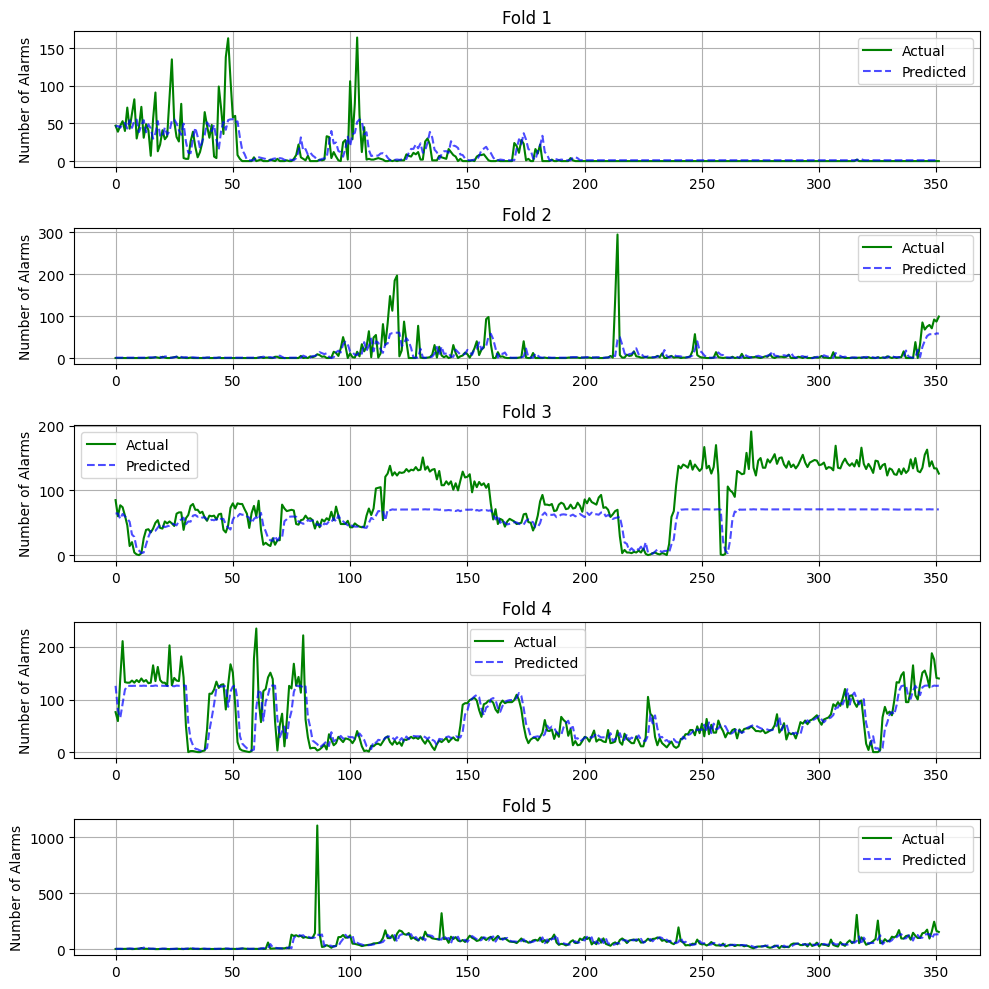

In [71]:
#| fig-cap: LSTM Actual vs Predicted for All Folds
#| label: fig-lstm-actual-vs-predicted_lockback_long

def plot_rnn_tscv(rnn_models, rnn_model, val_loader_list):
    daily_alarms_index_list = []
    for _, test_idx in tscv.split(daily_alarms):
        daily_alarms_index_list.append(daily_alarms.index[test_idx])  

    fig, axes = plt.subplots(
        nrows=tscv.get_n_splits(),
        ncols=1,
        figsize=(10, 2 * tscv.get_n_splits())
    )

    for fold, (val_loader, ax, rnn_state, daily_alarm_index) in enumerate(
        zip(val_loader_list, axes, rnn_models, daily_alarms_index_list),
        start=1
    ):
        all_preds = []
        all_true = []

        rnn_model.load_state_dict(rnn_state)
        rnn_model.eval()

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = rnn_model(xb)
                all_preds.append(preds.detach().cpu().numpy())
                all_true.append(yb.detach().cpu().numpy())

        preds = np.vstack(all_preds)
        true = np.vstack(all_true)

        ax.plot( true, label='Actual', color='green')
        ax.plot( preds, label='Predicted', color='blue', alpha=0.7, linestyle='--')
        ax.set_title(f'Fold {fold}')
        ax.set_ylabel('Number of Alarms')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
lstm_params = best_model_params['lstm']
lstm_model = lstm_params['model']
lstm_models = lstm_params['model_states']
val_loader_list = lstm_params['val_loader_list']
plot_rnn_tscv(lstm_models, lstm_model, val_loader_list)

The optimized hyperparameters for the LSTM model are:

- Lookback window: 7
- Batch size: 16
- Hidden size: 25
- Number of layers: 1
- Learning rate: $3.4 \times 10^{-3}$


### Alarms with Exogenous Variables
@fig-lstm-actual-vs-predicted shows the time series cross-validation results of the model with exogenous variables.

In [ ]:

with open('best_model_params3.pkl', 'wb') as f:
    pickle.dump(best_model_params, f)
#print("Best:", study.best_params, study.best_value)

# runtime 46 minutes A100 GPU

In [56]:
rmse_scores = best_model_params['lstm']['rmse_scores']
print("RMSE per Fold:")
for i, s in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {s:.2f}")
    
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")

RMSE per Fold:
Fold 1: 23.88
Fold 2: 27.59
Fold 3: 52.42
Fold 4: 46.02
Fold 5: 74.72
Average RMSE: 44.93


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1127: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(


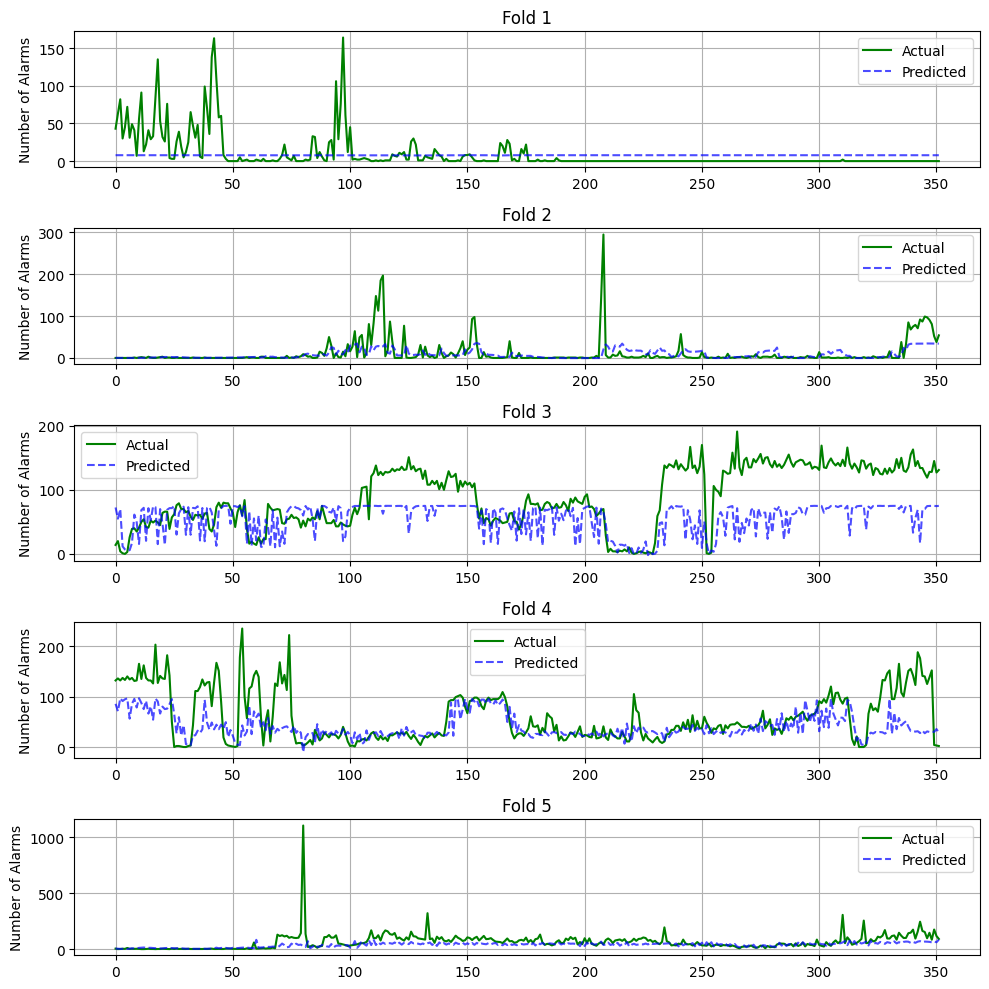

In [ ]:
#| fig-cap: LSTM Actual vs Predicted for All Folds
#| label: fig-lstm-actual-vs-predicted

def plot_rnn_tscv(rnn_models, rnn_model, val_loader_list):
    daily_alarms_index_list = []
    for _, test_idx in tscv.split(daily_alarms):
        daily_alarms_index_list.append(daily_alarms.index[test_idx])  

    fig, axes = plt.subplots(
        nrows=tscv.get_n_splits(),
        ncols=1,
        figsize=(10, 2 * tscv.get_n_splits())
    )

    for fold, (val_loader, ax, rnn_state, daily_alarm_index) in enumerate(
        zip(val_loader_list, axes, rnn_models, daily_alarms_index_list),
        start=1
    ):
        all_preds = []
        all_true = []

        rnn_model.load_state_dict(rnn_state)
        rnn_model.eval()

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = rnn_model(xb)
                all_preds.append(preds.detach().cpu().numpy())
                all_true.append(yb.detach().cpu().numpy())

        preds = np.vstack(all_preds)
        true = np.vstack(all_true)

        ax.plot( true, label='Actual', color='green')
        ax.plot( preds, label='Predicted', color='blue', alpha=0.7, linestyle='--')
        ax.set_title(f'Fold {fold}')
        ax.set_ylabel('Number of Alarms')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
lstm_params = best_model_params['lstm']
lstm_model = lstm_params['model']
lstm_models = lstm_params['model_states']
val_loader_list = lstm_params['val_loader_list']
plot_rnn_tscv(lstm_models, lstm_model, val_loader_list)


The optimized hyperparameters for the LSTM model are:

- Lookback window: 9
- Batch size: 16
- Hidden size: 106
- Number of layers: 2
- Learning rate: $9.9 \times 10^{-4}$


\subsection*{Conclusion}
Even though the lookback window search range is larger, the model consistently prefers smaller lookback values of 7 and 9. Once again, the model without exogenous variables achieves better performance. Overall, the LSTM performs worse than the RNN on the validation set, but shows improved performance on the test set (last fold).

Hyperparameter optimization is carried out using Optuna with 50 trials, resulting in total runtimes of approximately 57 minutes and 70 minutes, respectively, on an NVIDIA A100 GPU.


# Conclusion {#sec-conclusion}
In this project, we evaluated several time-series forecasting models to predict daily alarm counts based on historical patterns and exogenous variables. To reduce computational complexity, the data were aggregated at a daily level, and the models were trained to predict the alarm count for the following day. Visualizing the data helps to understand the overall pattern, trends, and unusual events. The total runtime of the complete pipeline was approximately 5 hours. Time series cross-validation is computationally expensive, feature selection, and neural network models in particular require more training time than classical approaches, especially when hyperparameter optimization is performed.

The data shows non‑stationary behavior with an upward trend but lacked clear seasonal patterns. First-order differencing was sufficient to achieve stationarity. Analysis of the ACF and PACF, along with power spectral density plots, indicates short-term dependencies, with only the most recent days contributing meaningful predictive information.
Categorical features were included using one-hot encoding. We evaluate all models using time-series cross-validation with 5 folds. For models that involve model selection, the first four folds are used for validation during model selection, and the final fold is used as a test set. This includes SARIMAX (selected exog), RNN, and LSTM:

The results for each model by fold, along with the average RMSE, are summarized in Table \ref{tab:rmse-scores}. It shows that models using only the alarm history generally perform better than models that include all exogenous variables. Although RNN (alarm) achieves the lowest average RMSE across all folds, this result should be interpreted with caution, since we used the first four folds for validation. Therefore, performance may be slightly optimistic, and the most reliable measure of generalization is the RMSE on Fold 5. LSTM (alarm) performs best on the last fold, although the validation error remains high compared to the other folds. SARIMAX without exogenous variables, and with selected exogenous variables, also have sligthly better results than the baseline model.

Adding all exogenous variables clearly worsens performance. This can be seen for SARIMAX (exog) as well as for RNN (exog) and LSTM (exog), which have much higher RMSE values and less stable results across folds. This suggests that the additional variables introduce noise and do not provide useful extra information in this setting.

Fold 5 is the most difficult for every model, with much higher RMSE values than the earlier folds. This indicates that the last time period is harder to predict, likely because it contains unusual changes or strong spikes that the models cannot learn well from the earlier data.


\begin{table}[ht]
\centering
\caption{RMSE by model across 5 time‑series cross‑validation folds (best per column in bold).}
\label{tab:rmse-scores}
\begin{tabular}{lrrrrrr}
\hline
Model & Fold 1 & Fold 2 & Fold 3 & Fold 4 & Fold 5 & Avg \\
\hline
Baseline                   & 19.14 & 26.47 & \textbf{16.59} & 28.31 & 81.82 & 34.47 \\
SARIMAX (alarm)          & 17.41 & 24.03 & 18.82 & 29.46 & 70.92 & 32.13 \\
SARIMAX (exog)             & 17.92 & 49.96 & 51.15 & 30.04 & 93.68 & 48.55 \\
SARIMAX (selected exog)    & 17.43 & 24.52 & 19.61 & 30.25 & 68.40 & 32.04 \\
XGBoost                    & 18.67 & 25.70 & 29.40 & 29.04 & 74.68 & 35.50 \\
RNN (alarm)          & 17.50 & \textbf{22.89} & 18.32 & 27.22 & 67.56 & \textbf{30.70} \\
RNN (exog)                 & 19.69 & 27.35 & 42.30 & 48.98 & 84.09 & 44.48 \\
LSTM (alarm)         & \textbf{17.25} & 23.58 & 45.02 & \textbf{26.31} & \textbf{61.07} & 34.65 \\
LSTM (exog)                & 23.88 & 27.59 & 52.42 & 46.02 & 74.72 & 44.93 \\
\hline
\end{tabular}
\end{table}


Across all models, extreme spikes are hard to predict. When a spike is reflected in the forecast, it often appears with a delay, meaning the model reacts after the true increase has already happened. 
The results also show that the models have problems predicting extreme spikes. In such cases, a more complex model or a special method for rare events may be needed, because simpler forecasting models often smooth sudden changes or react too late. Additional descriptive features can be extracted from each sliding window (e.g., minimum, maximum, peak counts). Exogenous variables should also be added carefully. Irrelevant variables can add noise and reduce generalization, so feature selection is often necessary. Domain knowledge could help identify early signals or leading indicators.

\newpage

# References
::: {#refs}
:::